# Great Energy Predictor - EDA

<a id='content2'></a>
## Content

1. [Data Description](#description2)
2. [Imports](#imports2)
3. [Exploratory Analysis](#eda)
    - [Building Analysis](#eda_bldg)
    - [Weather Analysis](#eda_wthr)
    - [Meter Analysis](#eda_metr)

<a id='description2'></a>
## 1. Data Description
[Back to top](#content2)

The data is a 2016 collection of energy meter readings (from over 1,000 buildings in 16 sites around the world) and weather measurements (from the nearest weather station for each site). It consists of 3 relational files of tabular data with the following features:
##### 1. train.csv - contains energy consumption measurements from 4 types of building meters in 2016
    - building_id - identifies the building
        - There are 1449 buildings in 16 sites around the world in this dataset
    - meter - meter type (not all buildings have all meter types)
        - 0 - electricity
        - 1 - chilldwater
        - 2 - steam
        - 3 - hotwater
    - timestamp - date and time of the meter reading
        - This dataset contains measurements over a span of an entire year
    - meter_reading - Energy consumption, (this is the target variable)
        - Electric meter readings are in kWh
            - Electric meter readings for site 0 are in kBTU
        - Chilled water meter readings are in tons
            - Chilled water meter readings for site 0 are in kBTU
        - Steam meter readings are in lbs
        - Hot water meter readings are in mmBTU
##### 2. weather_train.csv - contains weather measurements in 2016 from the weather station that is closest to the site
    - site_id - identifies the site where the building is
    - timestamp - date and time of the weather measurements
    - air_temperature - air temperature, in degrees Celsius
    - cloud_coverage - portion of the sky covered by clouds, in oktas
    - dew_temperature - temperature at which dew forms, in degrees Celsius
    - precip_depth_1_hr - measure of rainfail in 1 hour, in millimeters (mm)
    - sea_level_pressure - atmospheric pressure at sea level, in millibar (mbar) or hectopascals (hPa)
    - wind_direction - compass direction of the wind (0 - 360)
    - wind_speed - wind speed, in meters per second (m/s)
##### 3. building_metadata.csv - contains details about the buildings in the dataset
    - site_id - identifies the site where the building is
    - building_id - identifies the building
    - primary_use - what the building is used for (based on EnergyStar's property types)
    - square_feet - gross floor area of the building, in square feet (ft^2)
    - year_built - year the building was opened
    - floor_count - number of floors the building has
    
This data was retrieved from a public Kaggle competition hosted by ASHRAE.
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction/data

<a id='imports2'></a>
## 2. Imports
[Back to top](#content2)

##### Import libraries

In [1]:
%matplotlib inline

import src.utils as udf

import gc
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# import ray.dataframe as pd
# import stumpy
# from fbprophet import Prophet as fb

In [2]:
# Default plot settings
sns.set(rc={'figure.figsize': (16, 4), 
            'font.size': 12})

##### Import data

In [3]:
data_path = '../data/output/'

In [4]:
building = pd.read_csv(f'{data_path}clean_building.csv').iloc[:, 1:]
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 7 columns):
site_id            1449 non-null int64
building_id        1449 non-null int64
primary_use        1449 non-null object
square_feet        1449 non-null int64
year_built         1449 non-null int64
floor_count        1449 non-null int64
in_construction    1449 non-null int64
dtypes: int64(6), object(1)
memory usage: 79.4+ KB


In [5]:
building = udf.reduce_mem(building)
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 7 columns):
site_id            1449 non-null uint8
building_id        1449 non-null uint16
primary_use        1449 non-null category
square_feet        1449 non-null uint32
year_built         1449 non-null uint16
floor_count        1449 non-null uint8
in_construction    1449 non-null uint8
dtypes: category(1), uint16(2), uint32(1), uint8(3)
memory usage: 17.9 KB


In [6]:
weather = pd.read_csv(f'{data_path}clean_weather.csv', parse_dates=['timestamp']).iloc[:, 1:]
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140544 entries, 0 to 140543
Data columns (total 9 columns):
site_id               140544 non-null int64
timestamp             140544 non-null datetime64[ns]
air_temperature       140544 non-null float64
cloud_coverage        140544 non-null int64
dew_temperature       140544 non-null float64
precip_depth_1_hr     140544 non-null float64
sea_level_pressure    140544 non-null float64
wind_direction        140544 non-null int64
wind_speed            140544 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 9.7 MB


In [7]:
weather = udf.reduce_mem(weather)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140544 entries, 0 to 140543
Data columns (total 9 columns):
site_id               140544 non-null uint8
timestamp             140544 non-null datetime64[ns]
air_temperature       140544 non-null float32
cloud_coverage        140544 non-null uint8
dew_temperature       140544 non-null float32
precip_depth_1_hr     140544 non-null float32
sea_level_pressure    140544 non-null float32
wind_direction        140544 non-null uint16
wind_speed            140544 non-null float32
dtypes: datetime64[ns](1), float32(5), uint16(1), uint8(2)
memory usage: 4.3 MB


In [8]:
meter = pd.read_csv(f'{data_path}clean_meter.csv', parse_dates=['timestamp']).iloc[:, 1:]
meter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 6 columns):
site_id          int64
building_id      int64
meter            int64
type             object
timestamp        datetime64[ns]
meter_reading    float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 925.4+ MB


In [9]:
meter = udf.reduce_mem(meter)
meter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 6 columns):
site_id          uint8
building_id      uint16
meter            uint8
type             category
timestamp        datetime64[ns]
meter_reading    float32
dtypes: category(1), datetime64[ns](1), float32(1), uint16(1), uint8(2)
memory usage: 327.8 MB


<a id='eda'></a>
## 3. Exploratory Analysis
To:
- [Building Analysis](#eda_bldg)
- [Weather Analysis](#eda_wthr)
- [Meter Analysis](#eda_metr)
- [Top](#content2)

<a id='eda_bldg'></a>
### Building Analysis
[Back to 3. Exploratory Analysis](#eda)

##### Inspect the data

In [10]:
udf.get_stats(building)

site_id building_id primary_use square_feet year_built floor_count  \
count_       1449        1449        1449        1449       1449        1449   
missing_        0           0           0           0          0           0   
mean_     6.95238         724           -     92111.8    1967.12     3.55763   
std_      5.00343     418.435           -      110770    21.7681     3.37171   
min_            0           0           -         283       1900           1   
max_           15        1448           -      875000       2017          26   
dtype_      uint8      uint16    category      uint32     uint16       uint8   

         in_construction  
count_              1449  
missing_               0  
mean_         0.00552105  
std_           0.0741239  
min_                   0  
max_                   1  
dtype_             uint8

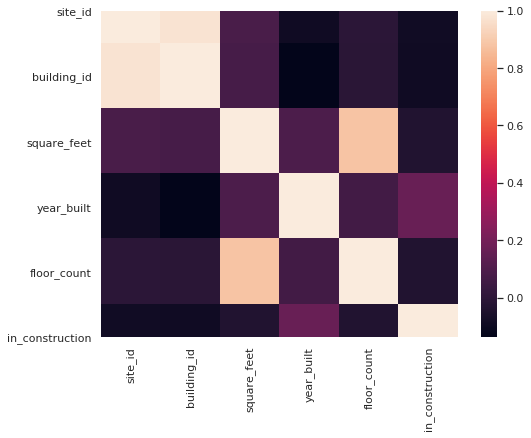

In [11]:
fig = plt.figure(figsize=(8, 6))
sns.heatmap(building.corr())

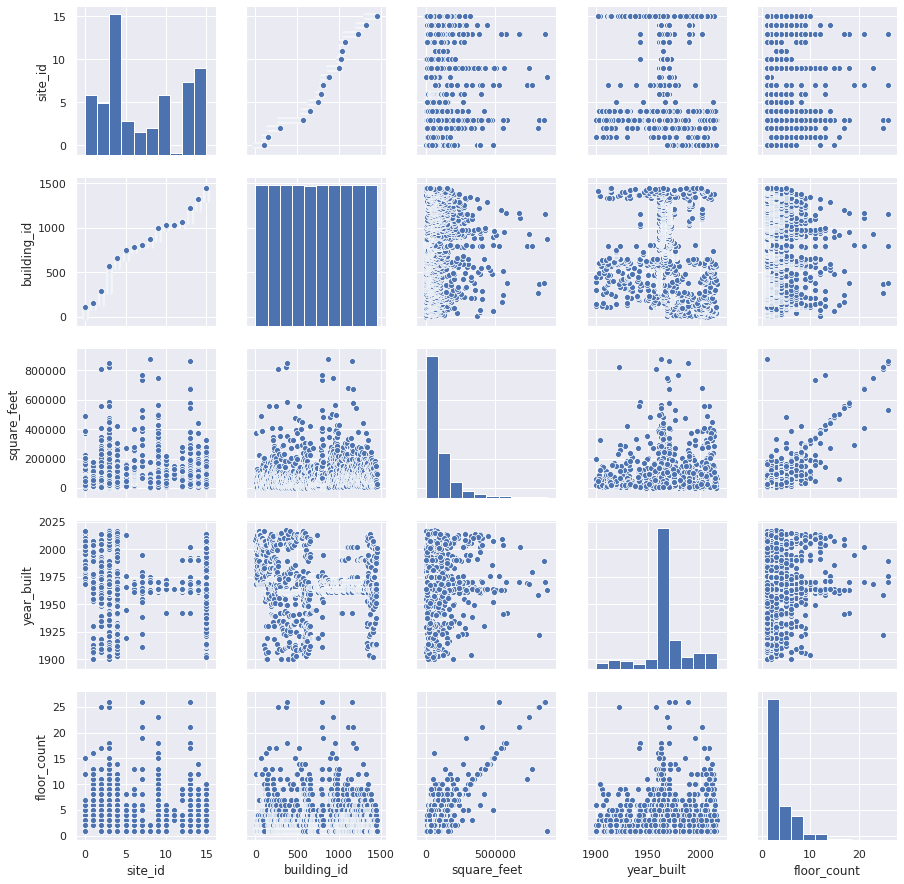

In [12]:
sns.pairplot(building.drop('in_construction', axis=1))

##### Visualize the data by site

Text(0.5, 1.0, 'Buildings in each site')

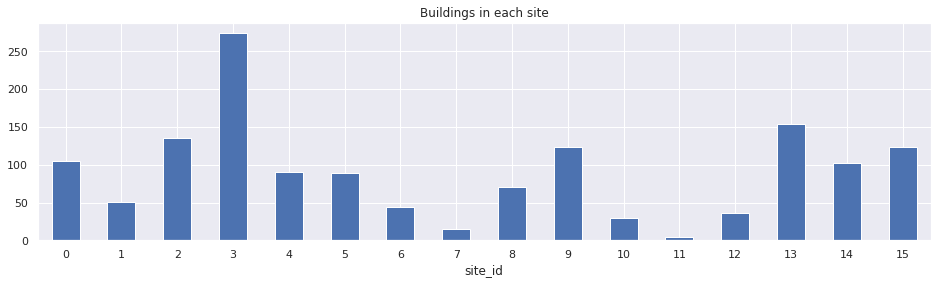

In [13]:
# Amount of buildings in each site
building.groupby('site_id').building_id.count().plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Buildings in each site')

In [14]:
# Average values for each site
avg_bysite = building.groupby('site_id')[['square_feet', 'year_built', 'floor_count']].mean().astype(int)

# Total average values for all sites
avg_bysite.loc['All'] = building[['square_feet', 'year_built', 'floor_count']].mean().astype(int)

avg_bysite

square_feet  year_built  floor_count
site_id                                      
0              86394        1995            3
1              65002        1961            7
2              99542        1974            3
3              75290        1961            2
4              92876        1954            5
5              47612        1962            2
6              91857        1966            3
7             323634        1958            8
8              29712        1964            1
9             144874        1965            4
10             71152        1965            2
11            104563        1964            3
12             79338        1966            2
13            128342        1970            4
14             95111        1969            3
15             83921        1962            3
All            92111        1967            3

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

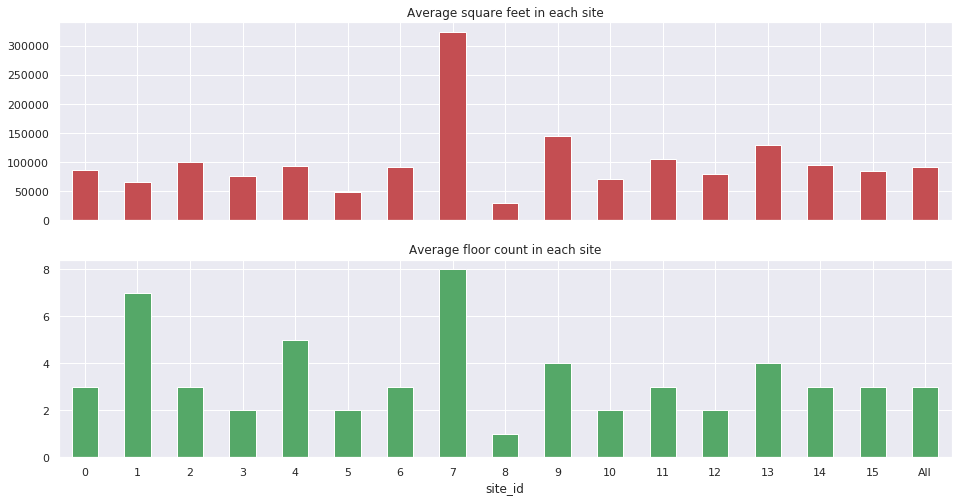

In [15]:
# Subplot titles
titles = ['Average %s in each site' % col for col in ['square feet', 'floor count']]

# Average square_feet and floor_count
avg_bysite.drop('year_built', axis=1).plot(kind='bar', subplots=True, figsize=(16, 8), title=titles, legend=False, color=['r', 'g'])
plt.xticks(rotation=0)

In [16]:
# Average year_built
avg_bysite.year_built.plot(kind='bar')
plt.ylim(1900, 2000)
plt.xticks(rotation=0)
plt.title('Average year built of buildings in each site')

Text(0.5, 1.0, 'Average year built of buildings in each site')

Text(0.5, 1.0, 'Types of buildings')

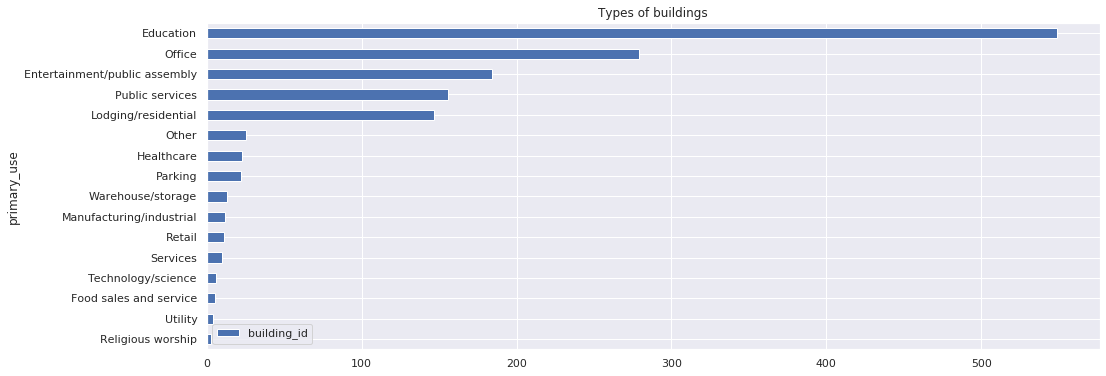

In [17]:
# Amount of buildings by type
use_ct = building.groupby('primary_use')[['building_id']].count().sort_values('building_id')

use_ct.plot(kind='barh', figsize=(16, 6))
plt.title('Types of buildings')

In [18]:
# Amount of each type of building in each site
use_bysite = building.pivot_table(index='site_id', columns='primary_use', values='building_id', aggfunc='count', fill_value=0)
use_bysite

primary_use  Education  Entertainment/public assembly  Food sales and service  \
site_id                                                                         
0                   30                              5                       0   
1                   22                              1                       0   
2                   61                             21                       2   
3                   92                             44                       0   
4                   66                              9                       0   
5                   49                             18                       0   
6                   15                              4                       0   
7                   15                              0                       0   
8                    0                             24                       0   
9                   63                             18                       0   
10                  14                              4                       0   
11                   5                              0                       0   
12                  20                              2                       0   
13                  25                              8                       1   
14                  26                             10                       2   
15                  46                             16                       0   

primary_use  Healthcare  Lodging/residential  Manufacturing/industrial  \
site_id                                                                  
0                     0                   27                         0   
1                     0                   10                         0   
2                     1                   12                         0   
3                     6                   11                         0   
4                     0                    4                         0   
5                     1                    1                         3   
6                     0                   12                         0   
7                     0                    0                         0   
8                     0                    0                         0   
9                     0                   19                         0   
10                    0                    3                         0   
11                    0                    0                         0   
12                    0                    0                         0   
13                    4                   10                         6   
14                   10                    9                         0   
15                    1                   29                         3   

primary_use  Office  Other  Parking  Public services  Religious worship  \
site_id                                                                   
0                24      5        8                0                  0   
1                16      0        0                2                  0   
2                24      0        3                6                  1   
3                23      4        1               86                  1   
4                 0      0        3                6                  0   
5                11      1        0                5                  0   
6                11      0        0                2                  0   
7                 0      0        0                0                  0   
8                 7      9        0               28                  0   
9                17      0        0                2                  0   
10                5      3        0                0                  0   
11                0      0        0                0                  0   
12                9      0        0                1                  0   
13               75      3        7                5                  0   
14      

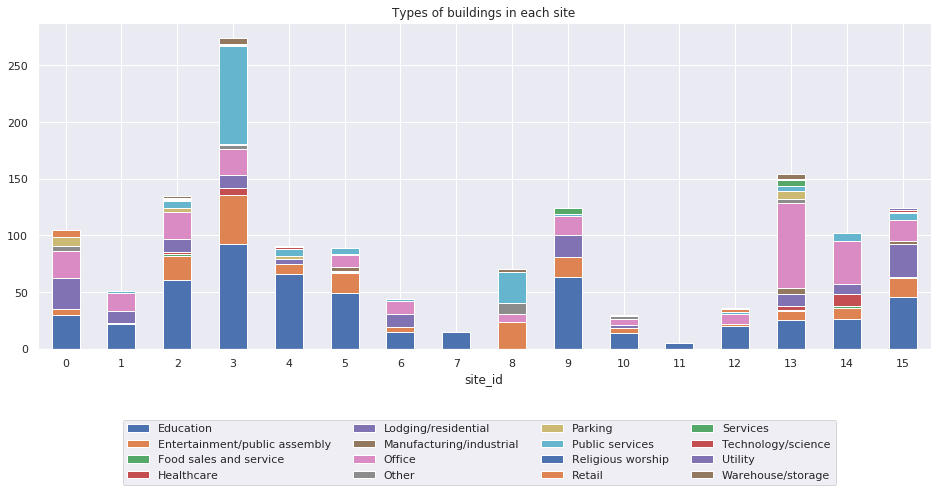

In [19]:
# Building type makeup of each site
use_bysite.plot(kind='bar', stacked=True, figsize=(16, 6))
plt.xticks(rotation=0)
plt.title('Types of buildings in each site')
plt.legend(bbox_to_anchor=(0.9, -0.2), ncol=4, fancybox=True)

In [20]:
del use_bysite, avg_bysite, titles, fig

Average `square_feet`, `floor_count`, and `year_built` by site:
- Site 3 has the most buildings so it has the most weight on the total
    - Half of the `year_built` values and all of the `floor_count` values in site 3 were originally missing
        - The missing `year_built` values were imputed with the median `year_built` of the corresponding type of building
        - The missing `floor_count` values were imputed based on the buildings' `square_feet` divided into 26 bins
- Site 7 has the largest buildings on average, both in terms of `square_feet` and `floor_count`
    - But it also has the 2nd least amount of buildings so there's actually less weight on this site
- Site 1 and site 4 also have taller buildings on average
- Most of the buildings in site 8 have only 1 floor
- Site 0 has a lot of newer buildings

Summary of `primary_use`:
- Education and office buildings make up more than half of the buildings
- Some, if not most, of these sites may be universities
    - Education buildings are a major portion of every site except site 8
- Sites 13 and 14 may be commercial areas since they contain a lot of office buildings
- Sites 3 and 8 have a lot of public services buildings

Note: These insights only reflect the buildings in the data.

##### Visualize the data by the type of building

In [21]:
# Average values for each building type
avg_byuse = building.groupby('primary_use').mean().astype(int)[['square_feet', 'year_built', 'floor_count']]

# Sort based on the amount of each building type present in the data
avg_byuse = avg_byuse.reindex(use_ct.index)

avg_byuse

square_feet  year_built  floor_count
primary_use                                                        
Religious worship                    11276        1974            1
Utility                              31095        1975            1
Food sales and service               38485        1992            1
Technology/science                   59176        1940            3
Services                            200659        1967            6
Retail                               39298        1992            1
Manufacturing/industrial             41120        1963            1
Warehouse/storage                    45584        1976            2
Parking                             279341        1997            8
Healthcare                          140480        1986            4
Other                                31456        1972            1
Lodging/residential                  85368        1970            3
Public services                      64947        1962            2
Entertainment/public assembly        80584        1966            3
Office                               87065        1970            3
Education                           104329        1963            4

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

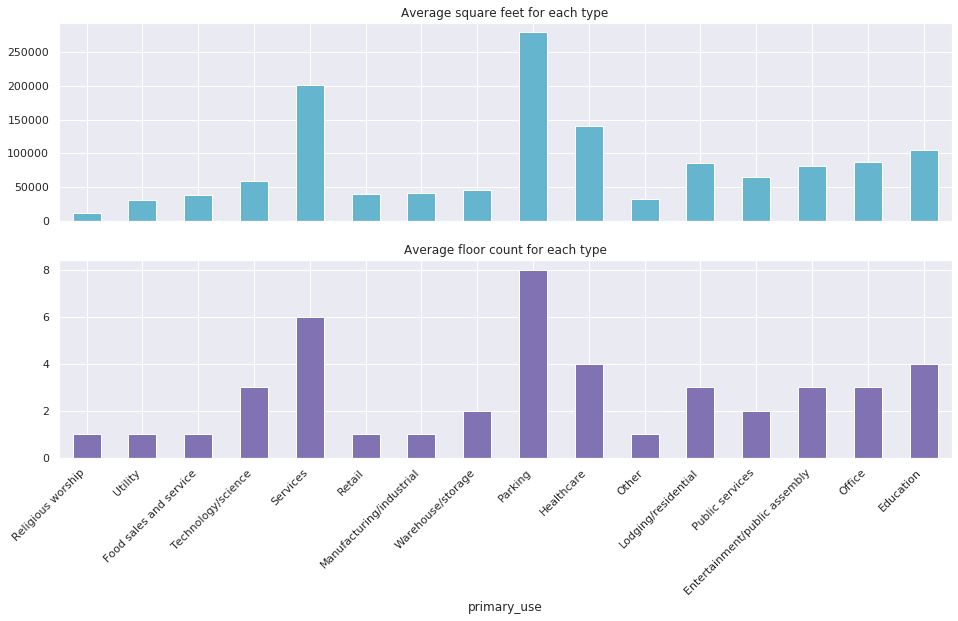

In [22]:
# Subplot titles
titles = ['Average %s for each type' % col for col in ['square feet', 'floor count']]

# Average square_feet and floor_count
avg_byuse[['square_feet', 'floor_count']].plot(kind='bar', subplots=True, figsize=(16, 8), title=titles, legend=False, color=['c', 'm'])
plt.xticks(rotation=45, ha='right')

Text(0.5, 1.0, 'Average year built of buildings for each type')

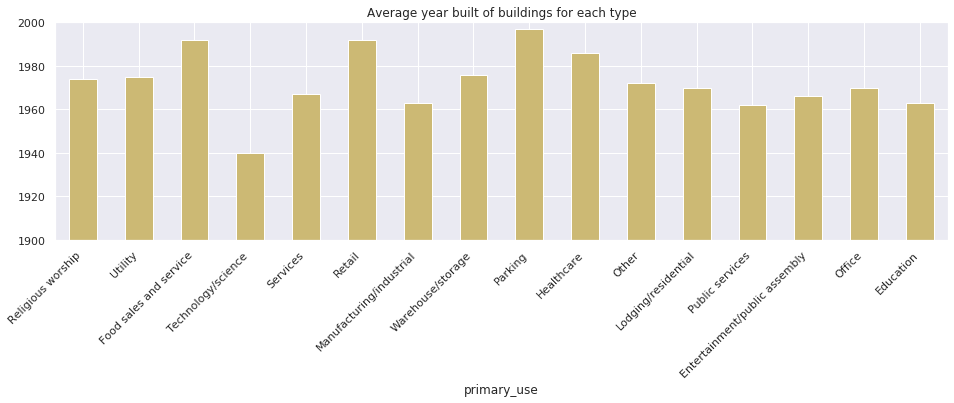

In [23]:
# Average year_built
avg_byuse.year_built.plot(kind='bar', figsize=(16, 4), color='y')
plt.ylim(1900, 2000)
plt.xticks(rotation=45, ha='right')
plt.title('Average year built of buildings for each type')

In [24]:
del use_ct, avg_byuse, titles

Average `square_feet`, `year_built`, and `floor_count` for each type of building:
- As education and office buildings populate more than half of the data, it's natural to see their averages line up with the total averages because they have more weight in contributing to the total averages
- The largest buildings on average (in terms of `square_feet` and `floor_count`) are parking structures, followed by service buildings then health care buildings
- On average, the tallest buildings are technology/science buildings, which are also the oldest buildings
- The newest buildings on average are retail, parking structures, and food sales/services

##### Check the distribution and outliers of the `square_feet` column

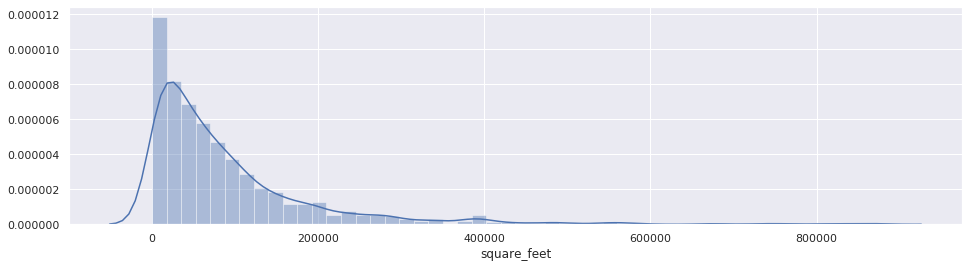

In [25]:
sns.distplot(building.square_feet)

In [26]:
# Use the mean + 3 standard deviations as a standard to filter for outliers
mean_3std = int(building.square_feet.mean() + (3 * building.square_feet.std()))

# Find outliers
building[building.square_feet > mean_3std].shape[0]

29

In [27]:
del mean_3std
gc.collect()

144

The `square_feet` values are very skewed to the right with about 29 outliers. The threshold for defining outliers here was anything larger than the mean plus 3 standard deviations, which in a normal distribution, contains 99.7% of the data.* Since a lot of the `year_built` and `floor_count` data was originally missing, plotting the distribution won't give any meaningful information because it wouldn't be an accurate representation of the real data.

Note: The `square_feet` data is not normally distributed. This outlier definition was an arbitrary choice.

<a id='eda_wthr'></a>
### Weather Analysis
[Back to 3. Exploratory Analysis](#eda)

##### Inspect the data

In [28]:
udf.get_stats(weather)

site_id       timestamp air_temperature cloud_coverage  \
count_     140544          140544          140544         140544   
missing_        0               0               0              0   
mean_         7.5               -         14.3556        2.47453   
std_      4.60979               -         10.6698        2.64193   
min_            0               -           -28.9              0   
max_           15               -            47.2              9   
dtype_      uint8  datetime64[ns]         float32          uint8   

         dew_temperature precip_depth_1_hr sea_level_pressure wind_direction  \
count_            140544            140544             140544         140544   
missing_               0                 0                  0              0   
mean_             7.2977           2.40642            1016.13        216.404   
std_             9.82486           13.3647             7.8846        104.689   
min_                 -35                 0              968.2             10   
max_                26.1               343             1045.5            360   
dtype_           float32           float32            float32         uint16   

         wind_speed  
count_       140544  
missing_          0  
mean_        3.5593  
std_        2.33377  
min_              0  
max_             19  
dtype_      float32

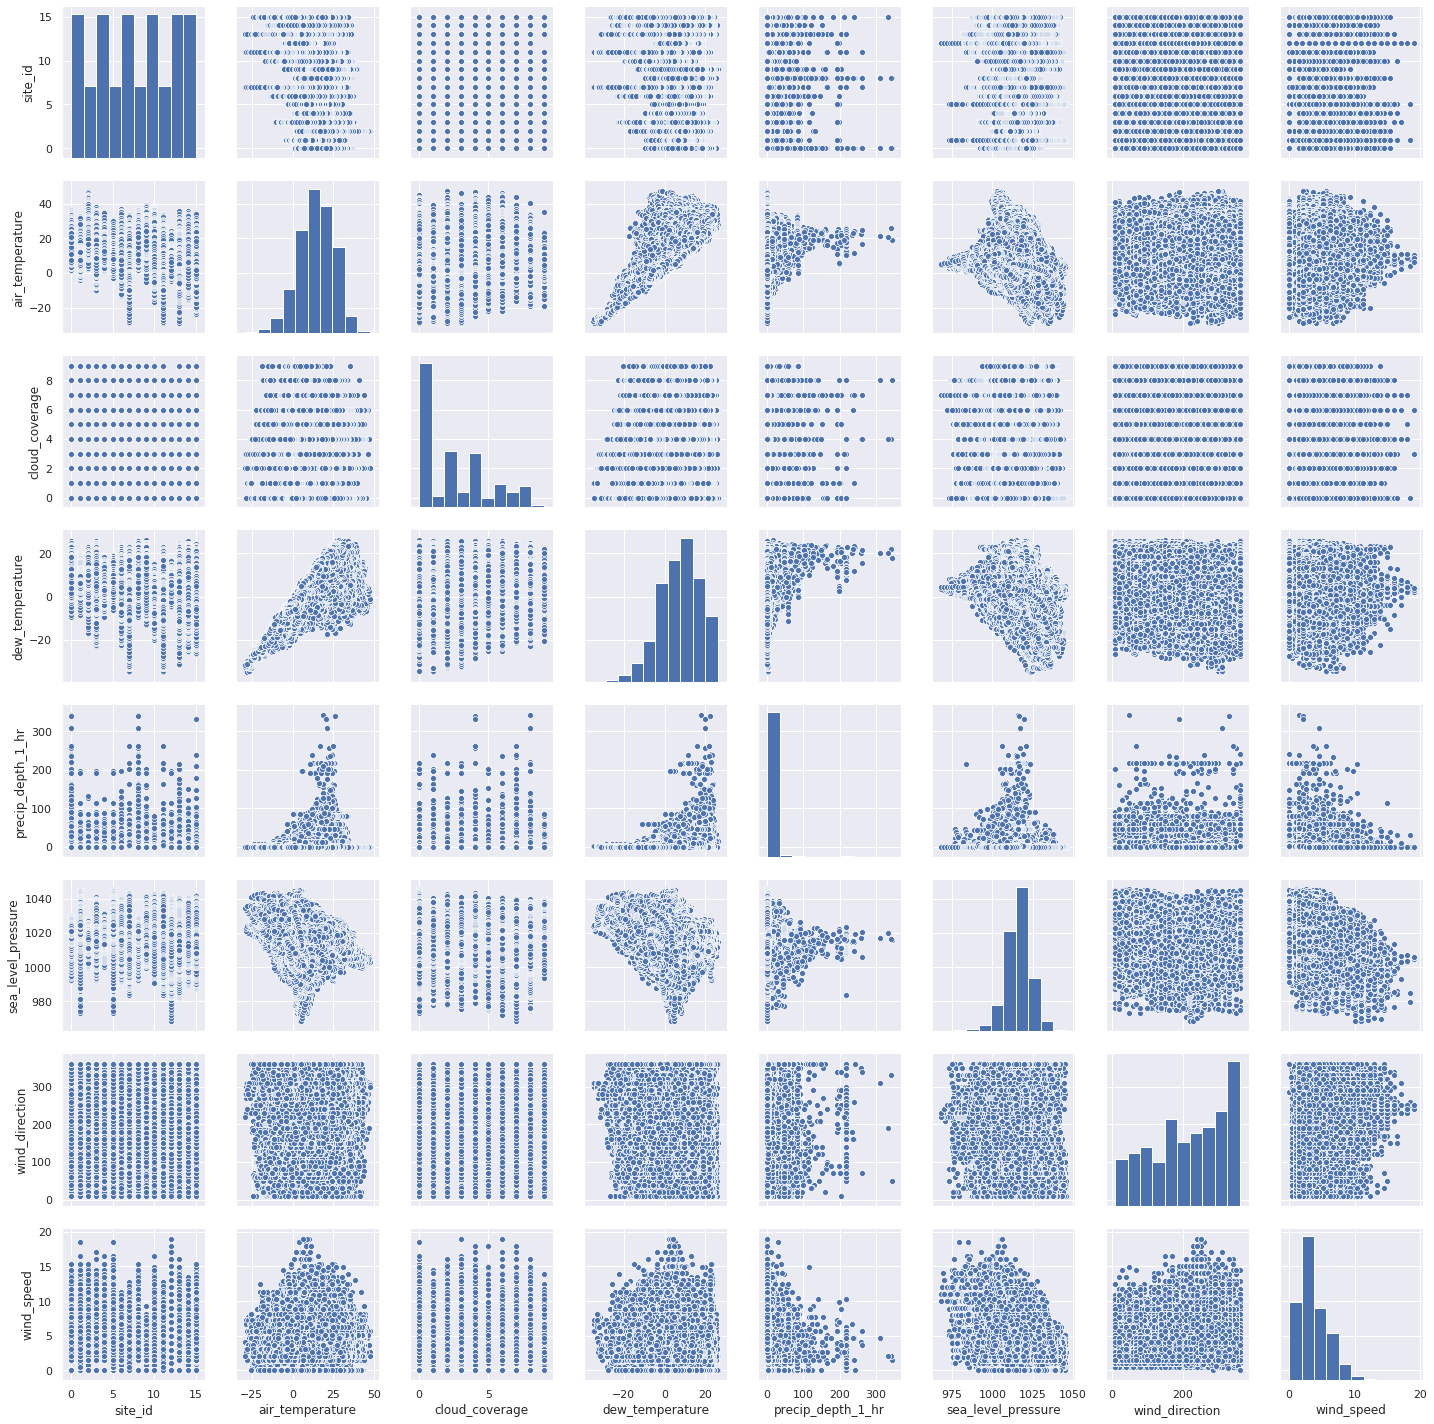

In [29]:
sns.pairplot(weather)

##### Visualize by site

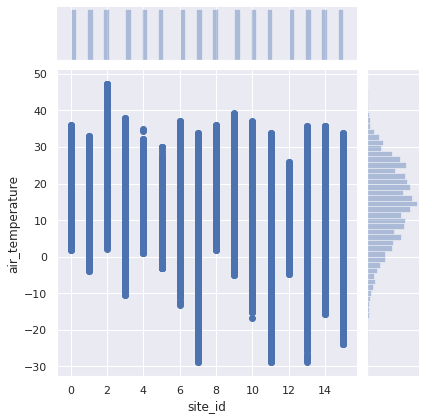

In [30]:
sns.jointplot('site_id', 'air_temperature', data=weather, height=6)

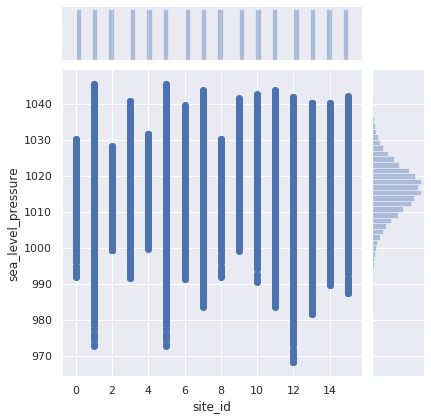

In [31]:
sns.jointplot('site_id', 'sea_level_pressure', data=weather, height=6)

These plots support the following claims made during the cleaning process:
- Sites 1, 5, and 12 are near each other
- Sites 7, 11, and 15 are near each other in a colder region
    - Site 13 may also be near these 3 sites

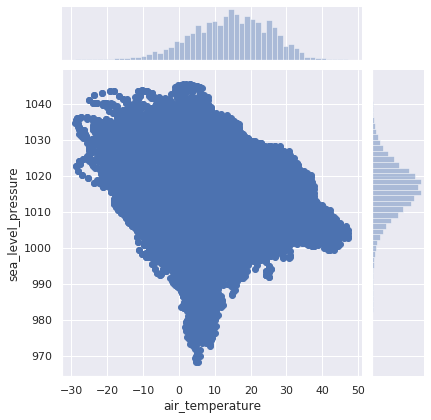

In [32]:
sns.jointplot('air_temperature', 'sea_level_pressure', data=weather, height=6)

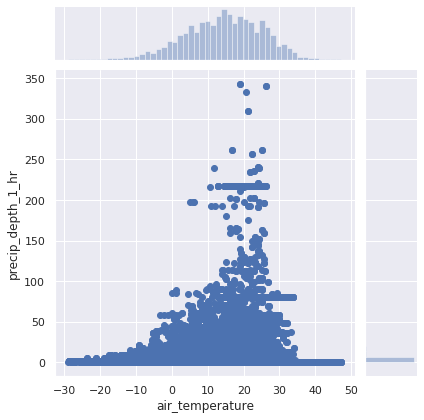

In [33]:
sns.jointplot('air_temperature', 'precip_depth_1_hr', data=weather, height=6)

Observations:
- `air_temperature` and `sea_level_pressure` are normally distributed
- The highest and lowest `sea_level_pressure` both occur at an `air_temperature` of about 5 degrees Celsius
- At the coldest `air_temperature`s, the `sea_level_pressure` is generally higher
- At the hottest `air_temperature`s, the `sea_level_pressure` is about 1005 mbar
- The most rain occurs at `air_temperature`s of around 5 to 25 degrees Celsius

##### Time series analysis

In [34]:
# Extract 1 site and downsample to daily frequency
wthr0_day = udf.get_site(weather, 0, time_idx=True).resample('d').mean()
wthr0_day.head()

air_temperature  cloud_coverage  dew_temperature  \
timestamp                                                      
2016-01-01        23.337500        5.333333        20.020834   
2016-01-02        19.537500        6.041667        15.325000   
2016-01-03        14.829166        8.000000        12.479167   
2016-01-04        12.666667        4.458333         4.429167   
2016-01-05        14.058333        2.541667         7.066667   

            precip_depth_1_hr  sea_level_pressure  wind_direction  wind_speed  
timestamp                                                                      
2016-01-01           0.002083         1018.960938      272.916667    1.854167  
2016-01-02           0.000833         1018.966187      167.500000    3.925000  
2016-01-03           0.794583         1017.241638      276.666667    5.000000  
2016-01-04           0.750833         1015.647461      318.333333    4.283333  
2016-01-05           0.000000         1022.370850      142.083333    6.258333

(array([16801, 16832, 16861, 16892, 16922, 16953, 16983, 17014, 17045,
        17075, 17106, 17136, 17166]), <a list of 13 Text xticklabel objects>)

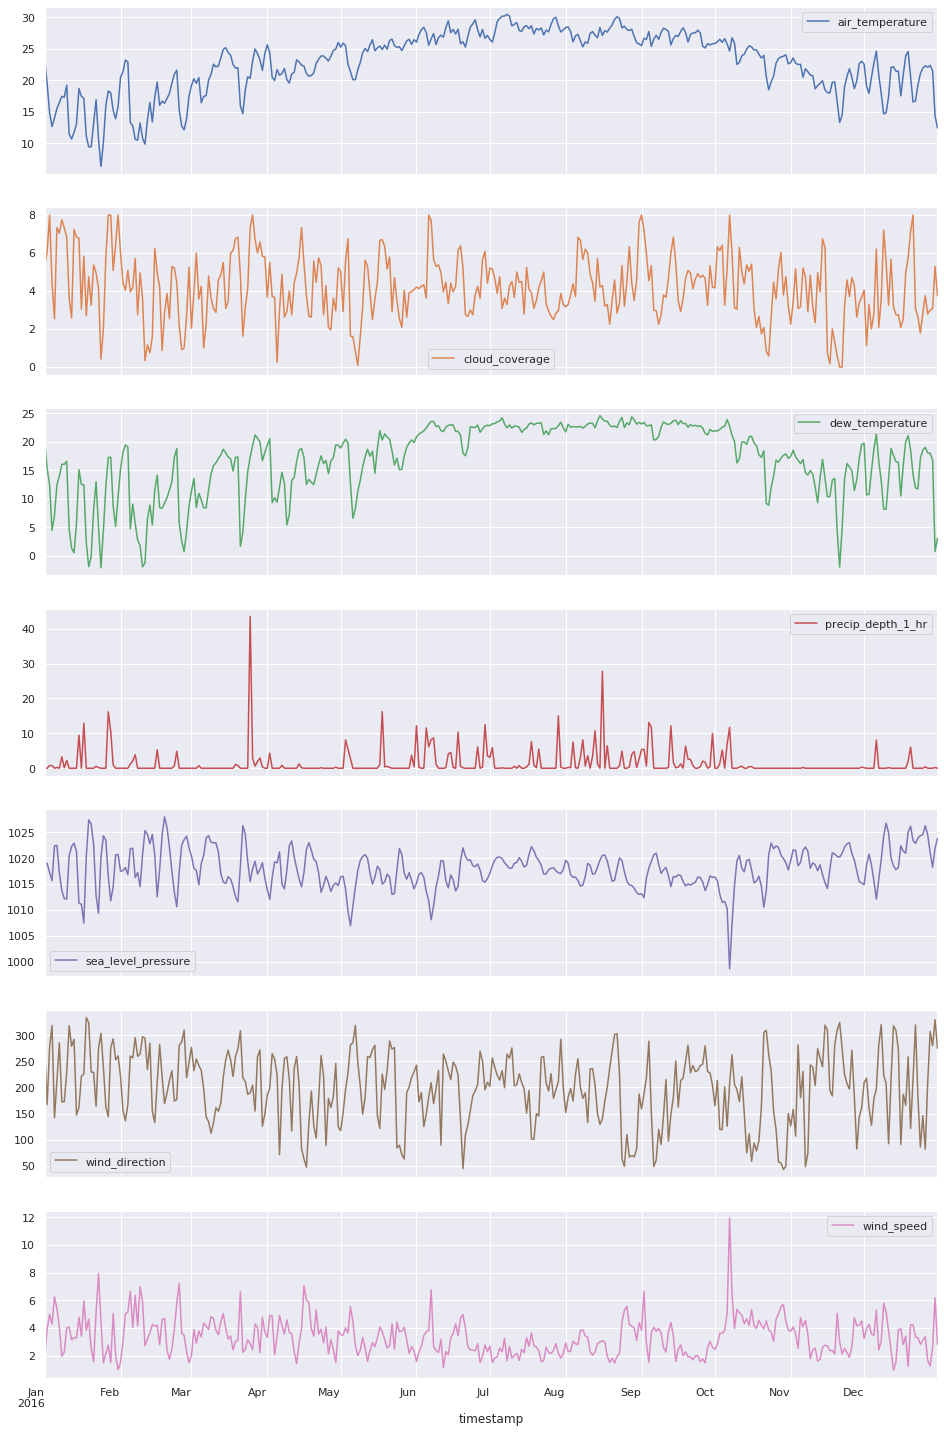

In [35]:
# Daily weather in site 0
wthr0_day.plot(subplots=True, figsize=(16, 28))
plt.xticks(rotation=0)

In [36]:
del wthr0_day

Observations:
- As expected, there is a rise in temperature around summertime
- The oscillations in `cloud_coverage` and `wind_direction` have a lower amplitude (wave height) during the summer months
- A lot of rain is seen at the end of March and in the middle of August
- The deepest dip in `sea_level_pressure` occurs at approximately the same time as the highest peak in `wind_speed`

In [37]:
# Extract hour from timestamp
weather['hour'] = weather.timestamp.dt.hour

# Site 4 hourly weather
wthr4 = udf.get_site(weather, 4).groupby('hour').mean()
wthr4

air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  \
hour                                                                        
0           18.429235        2.587432        10.295629           0.376257   
1           17.559017        2.617486        10.228142           0.370847   
2           16.497814        2.587432        10.210110           0.324317   
3           15.537705        2.532787        10.153278           0.253197   
4           14.852733        2.461749        10.144262           0.275027   
5           14.421311        2.316940        10.099727           0.179426   
6           14.056830        2.240437        10.018306           0.182377   
7           13.726230        2.133880         9.959563           0.357158   
8           13.477595        2.054645         9.864481           0.280601   
9           13.225956        2.008197         9.719398           0.392650   
10          13.005737        2.071038         9.583607           0.114044   
11          12.836612        2.019126         9.484153           0.116776   
12          12.570765        2.087432         9.301366           0.103142   
13          12.376503        2.251366         9.248088           0.357131   
14          12.464208        2.366120         9.267487           0.373661   
15          12.968852        2.497268         9.444263           0.398388   
16          14.024863        2.543716         9.832139           0.365383   
17          15.154371        2.546448        10.150546           0.212404   
18          16.210655        2.500000        10.147541           0.168716   
19          17.238525        2.456284        10.051879           0.272459   
20          18.124863        2.409836         9.994263           0.070246   
21          18.772678        2.475410        10.024317           0.258716   
22          19.107103        2.521858        10.073771           0.215137   
23          19.016666        2.565574        10.167486           0.234180   

      sea_level_pressure  wind_direction  wind_speed  
hour                                                  
0            1016.129333      266.748634    5.947268  
1            1016.019714      266.188525    5.579782  
2            1016.091248      267.745902    5.095082  
3            1016.290588      265.491803    4.547267  
4            1016.573486      269.316940    4.071858  
5            1016.859009      267.745902    3.654645  
6            1016.994934      263.852459    3.403005  
7            1016.981750      260.983607    3.117213  
8            1016.929382      255.136612    3.054372  
9            1016.787415      242.841530    3.013934  
10           1016.684998      243.633880    2.960929  
11           1016.601562      239.565574    2.848361  
12           1016.558044      228.207650    2.635519  
13           1016.686462      218.286885    2.616120  
14           1016.958679      228.784153    2.683060  
15           1017.301270      234.467213    2.657650  
16           1017.619629      241.229508    2.749454  
17           1017.851440      234.781421    3.201366  
18           1017.991394      232.404372    3.548361  
19           1017.897095      243.784153    3.891257  
20           1017.478088      252.459016    4.604918  
21           1016.975708      257.322404    5.186066  
22           1016.556580      262.786885    5.649454  
23           1016.272949      263.374317    5.878415

([<matplotlib.axis.XTick at 0x7ff8833f4f28>,
 <a list of 24 Text xticklabel objects>)

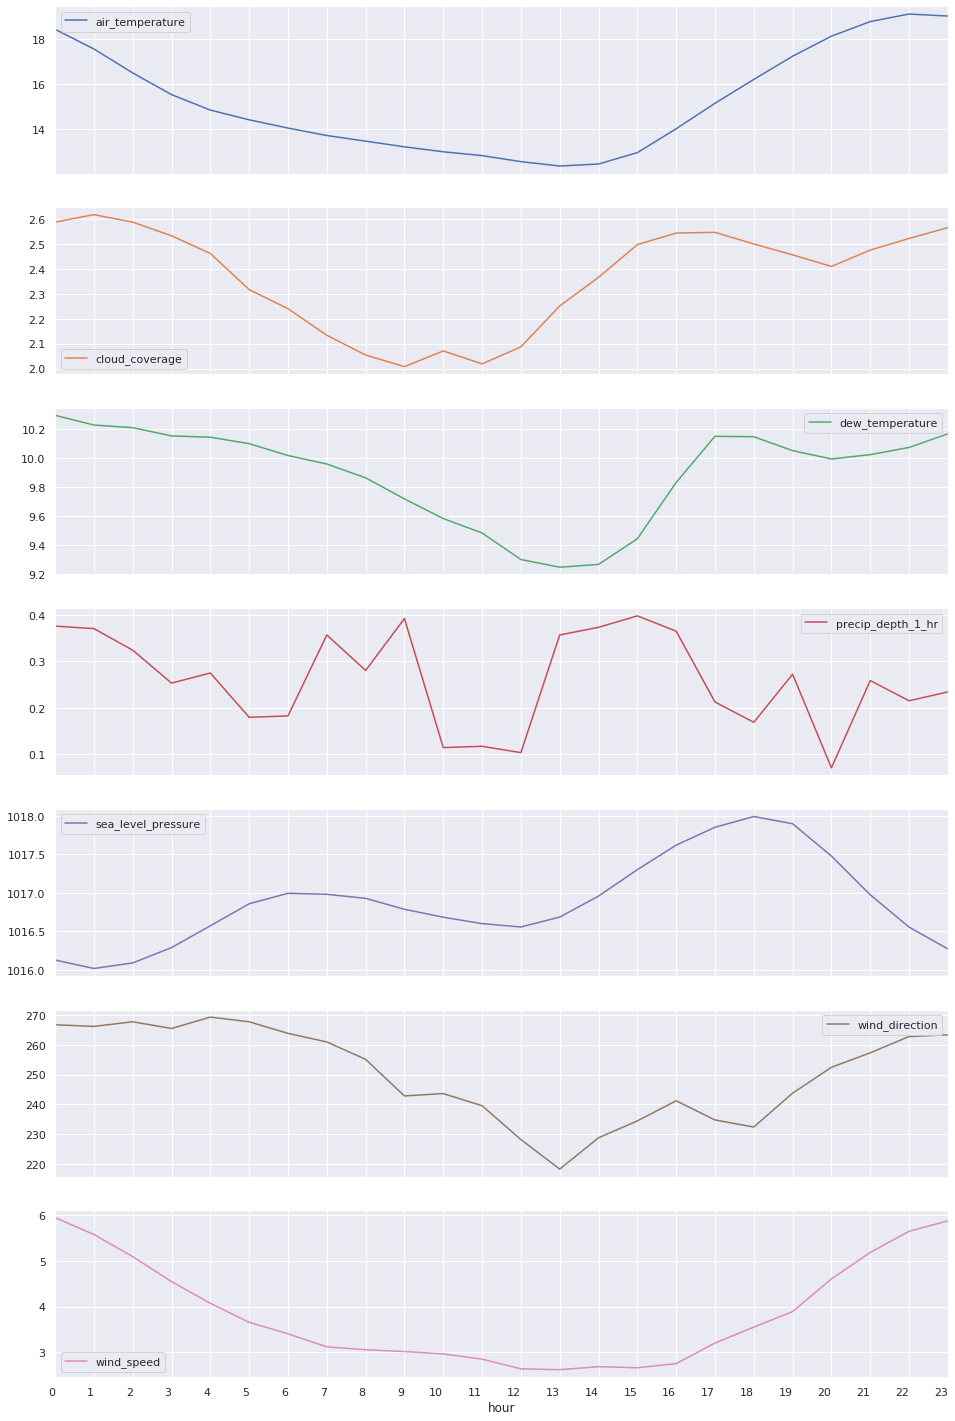

In [38]:
# Hourly weather of site 4 averaged across everyday in 2016
wthr4.plot(subplots=True, figsize=(16,28))
plt.xticks(range(24), rotation=0)

The temperature here doesn't look quite right. According to the `air_temperature` subplot, the temperature at this site is at the daily high at around 10 PM. There may be an error with the data.

##### Check the average hourly `air_temperature` at every site

In [39]:
# Average hourly air temperature by site
airtemp = pd.pivot_table(weather, index='hour', columns='site_id', values='air_temperature', aggfunc='mean')
airtemp

site_id         0          1          2          3          4          5   \
hour                                                                        
0        23.481148  10.001579  30.238525  16.589077  18.429235   9.669505   
1        22.490711   9.690836  29.461203  15.855423  17.559017   9.498009   
2        21.805464   9.438734  28.376053  15.239617  16.497814   9.357673   
3        21.277596   9.190984  27.166666  14.760608  15.537705   9.227823   
4        20.880054   9.017213  26.021038  14.364207  14.852733   9.100926   
5        20.408743   9.005191  24.926777  13.959352  14.421311   9.078324   
6        20.083059   9.263934  23.953552  13.655741  14.056830   9.201248   
7        19.730328   9.804645  23.201094  13.265697  13.726230   9.571202   
8        19.445263  10.562518  22.425957  12.994809  13.477595  10.093286   
9        19.265450  11.518579  21.620218  12.686066  13.225956  10.786885   
10       19.094851  12.520219  20.950274  12.393716  13.005737  11.510929   
11       19.113115  13.400620  20.350821  12.455738  12.836612  12.097160   
12       19.631695  14.103064  19.831694  12.917213  12.570765  12.565810   
13       21.205465  14.506161  19.415028  13.796994  12.376503  12.931075   
14       23.064207  14.849725  19.621311  14.863388  12.464208  13.081967   
15       24.689344  14.761679  20.757103  16.008196  12.968852  13.016086   
16       25.924591  14.430512  22.664480  17.064482  14.024863  12.740669   
17       26.713934  13.897540  24.577595  18.035519  15.154371  12.341593   
18       27.208197  13.310298  26.236612  18.787704  16.210655  11.854065   
19       27.518579  12.635965  27.619398  19.104372  17.238525  11.338405   
20       27.324043  12.026411  28.775682  19.199682  18.124863  10.789851   
21       26.818033  11.472677  29.677103  18.942034  18.772678  10.421255   
22       26.032515  10.980328  30.246449  18.249180  19.107103  10.196721   
23       24.760656  10.432116  30.457376  17.451639  19.016666   9.959180   

site_id         6          7          8          9          10         11  \
hour                                                                        
0        16.328962   9.239038  23.481148  24.332787  15.720219   9.239038   
1        15.329782   8.289638  22.490711  23.072620  14.725683   8.289638   
2        14.601912   7.553571  21.805464  21.981222  13.554645   7.553571   
3        13.974317   6.997800  21.277596  21.131147  12.117535   6.997800   
4        13.442349   6.476724  20.880054  20.340630  11.005112   6.476724   
5        13.037978   6.013010  20.408743  19.635519  10.353354   6.013010   
6        12.551912   5.619685  20.083059  19.121038   9.833760   5.619685   
7        12.207707   5.200534  19.730328  18.687979   9.360452   5.200534   
8        11.886603   4.802525  19.445263  18.307924   8.954655   4.802525   
9        11.601316   4.461576  19.265450  17.986612   8.584316   4.461576   
10       11.265932   4.225305  19.094851  17.731968   8.189239   4.225305   
11       11.200684   4.581613  19.113115  17.533607   7.815240   4.581613   
12       11.734354   5.306109  19.631695  17.354372   7.463052   5.306109   
13       13.000000   6.118958  21.205465  17.499454   7.320840   6.118958   
14       14.627758   7.141798  23.064207  18.521585   8.018605   7.141798   
15       16.134378   8.220030  24.689344  20.142897   9.376229   8.220030   
16       17.419399   9.170306  25.924591  21.760109  11.077377   9.170306   
17       18.366667   9.953102  26.713934  23.283607  12.718033   9.953102   
18       19.145796  10.603958  27.208197  24.468330  14.056284  10.603958   
19       19.623224  10.998811  27.518579  25.453005  15.004800  10.998811   
20       19.776554  11.150941  27.324043  26.143089  15.646995  11.150941   
21       19.538927  11.144646  26.818033  26.395901  16.086338  11.144646   
22       18.724318  10.739876  26.032515  26.263231  16.366940  10.739876   
23       17.614754  10.048343  24.760656  25.557104  16.327362  10.04834

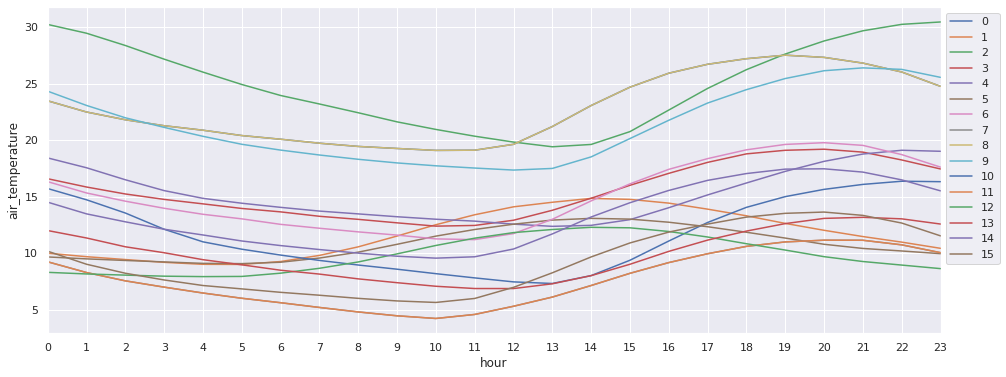

In [40]:
airtemp.plot(figsize=(16, 6), xticks=range(24))
plt.ylabel('air_temperature')
plt.legend(bbox_to_anchor=(1, 1))

This is not right at all. In many of the sites, the temperature is reaching its peak at night time hours and found at the daily low at morning to afternoon hours. This means the timestamps were most likely recorded in UTC (GMT).

This makes the problem more complicated but it does give some information. It supports the earlier claims that sites 1, 5, and 12 are nearby as they are in the same time zone. There is also support for sites 7, 11, and 15 also being in the nearby. Many other sites look like they are in the same time zone as sites 7, 11, and 15 too, so they may also be nearby. These claims are not definitive but there is a lot of information to support them.

In order to make better sense of the weather data, these timestamps will have to be converted to local time.

Thanks to the work of several Kagglers, most of the sites have been identified. The exact location of some of the sites are uncertain but the location has been narrowed down enough to determine the timezone for all sites. The locations and timezone of each site are as follows:
0. Orlando, Florida (GMT-5)
1. United Kingdom (GMT+0)
2. Arizona (GMT-7)
3. U.S. Eastern Time Zone (GMT-5)
4. Northern California (GMT-8)
5. United Kingdom (GMT+0)
6. U.S. Eastern Time Zone (GMT-5)
7. Southeastern Canada (GMT-5)
8. Orlando, Florida (GMT-5)
9. Texas (GMT-6)
10. U.S. Mountain Time Zone (GMT-7)
11. Southeastern Canada (GMT-5)
12. Dublin, Ireland (GMT+0)
13. Minnesota (GMT-6)
14. U.S. Eastern Time Zone (GMT-5)
15. U.S. Eastern Time Zone (GMT-5)

All the credit goes to Kaggle users: `poedator`, `patrick0302`, and `datadugong`.

Sources:
- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115698
- https://www.kaggle.com/patrick0302/locate-cities-according-weather-temperature
- https://www.kaggle.com/datadugong/locate-better-cities-by-weather-temp-fill-nans

##### Convert all the timestamps to local time

In [41]:
# List of timezone offsets for each site
# timezone = {0:-4, 1:0, 2:-7, 3:-4, 4:-7, 5:0, 6:-4, 7:-4, 8:-4, 9:-5, 10:-7, 11:-4, 12:0, 13:-5, 14:-4, 15:-4}
timezone = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]

# Adjust the timestamps and hours
weather = udf.to_local_time(weather, timezone)
weather['hour'] = weather.timestamp.dt.hour
weather.head()

site_id           timestamp  air_temperature  cloud_coverage  \
0        0 2015-12-31 19:00:00        25.000000               6   
1        0 2015-12-31 20:00:00        24.400000               4   
2        0 2015-12-31 21:00:00        22.799999               2   
3        0 2015-12-31 22:00:00        21.100000               2   
4        0 2015-12-31 23:00:00        20.000000               2   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0               0.01         1019.700012             360   
1             21.1               0.01         1020.200012              70   
2             21.1               0.00         1020.200012             360   
3             20.6               0.00         1020.099976             360   
4             20.0               0.01         1020.000000             250   

   wind_speed  hour  
0         0.0    19  
1         1.5    20  
2         0.0    21  
3         0.0    22  
4         2.6    23

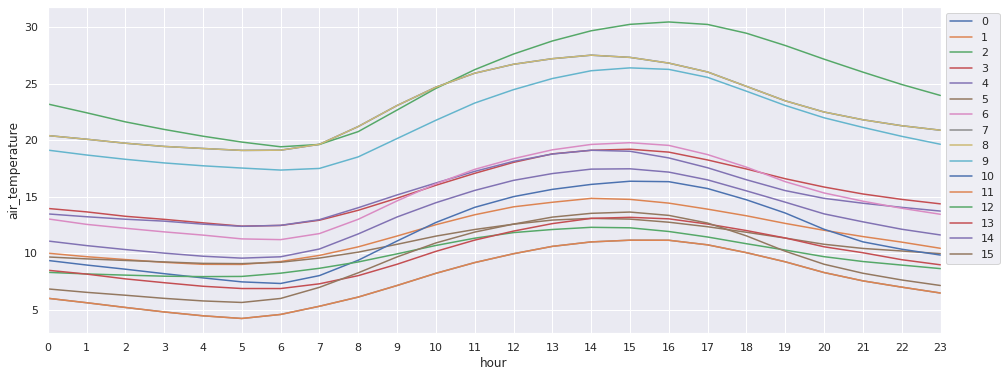

In [42]:
# Replot average hourly air temperature by site
airtemp = pd.pivot_table(weather, index='hour', columns='site_id', values='air_temperature', aggfunc='mean')
airtemp.plot(figsize=(16, 6), xticks=range(24))
plt.ylabel('air_temperature')
plt.legend(bbox_to_anchor=(1, 1))

Now the temperature data makes a lot more sense. They don't line up exactly but that may be because the temperature peaks at different times at each location.

Due to this offset, the data now contains a few hours from 2015 and is missing a few hours at the end of 2016 at most sites.

##### Reindex the weather data to include every hour in 2016 and use forward fill to fill the data for the missing hours

In [43]:
weather = udf.reidx_site_time(weather, tstart='1/1/2016 00:00:00', tend='12/31/2016 23:00:00')
weather.head()

site_id           timestamp  air_temperature  cloud_coverage  \
0        0 2016-01-01 00:00:00             19.4             4.0   
1        0 2016-01-01 01:00:00             21.1             6.0   
2        0 2016-01-01 02:00:00             21.1             6.0   
3        0 2016-01-01 03:00:00             20.6             6.0   
4        0 2016-01-01 04:00:00             21.1             6.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             19.4               0.00         1019.762939           360.0   
1             21.1               0.01         1019.400024           360.0   
2             21.1               0.00         1018.799988           210.0   
3             20.0               0.00         1018.099976           360.0   
4             20.6               0.00         1019.000000           290.0   

   wind_speed  hour  
0         0.0   0.0  
1         0.0   1.0  
2         1.5   2.0  
3         0.0   3.0  
4         1.5   4.0

In [44]:
weather['hour'] = weather.timestamp.dt.hour
weather = weather.fillna(method='ffill')
weather.tail(10)

site_id           timestamp  air_temperature  cloud_coverage  \
140534       15 2016-12-31 14:00:00              3.0             1.0   
140535       15 2016-12-31 15:00:00              2.8             2.0   
140536       15 2016-12-31 16:00:00              2.8             2.0   
140537       15 2016-12-31 17:00:00              2.2             2.0   
140538       15 2016-12-31 18:00:00              1.7             2.0   
140539       15 2016-12-31 19:00:00              1.7             2.0   
140540       15 2016-12-31 20:00:00              1.7             2.0   
140541       15 2016-12-31 21:00:00              1.7             2.0   
140542       15 2016-12-31 22:00:00              1.7             2.0   
140543       15 2016-12-31 23:00:00              1.7             2.0   

        dew_temperature  precip_depth_1_hr  sea_level_pressure  \
140534             -8.0               0.01         1007.320374   
140535             -8.9               0.01         1007.400024   
140536             -7.2               0.01         1007.500000   
140537             -6.7               0.01         1008.000000   
140538             -5.6               0.01         1008.500000   
140539             -5.6               0.01         1008.500000   
140540             -5.6               0.01         1008.500000   
140541             -5.6               0.01         1008.500000   
140542             -5.6               0.01         1008.500000   
140543             -5.6               0.01         1008.500000   

        wind_direction  wind_speed  hour  
140534           180.0         5.7    14  
140535           180.0         7.7    15  
140536           180.0         5.1    16  
140537           170.0         4.6    17  
140538           180.0         8.8    18  
140539           180.0         8.8    19  
140540           180.0         8.8    20  
140541           180.0         8.8    21  
140542           180.0         8.8    22  
140543           180.0         8.8    23

In [45]:
del airtemp, timezone, wthr4
gc.collect()

68

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff882a9bc18>,
      dtype=object)

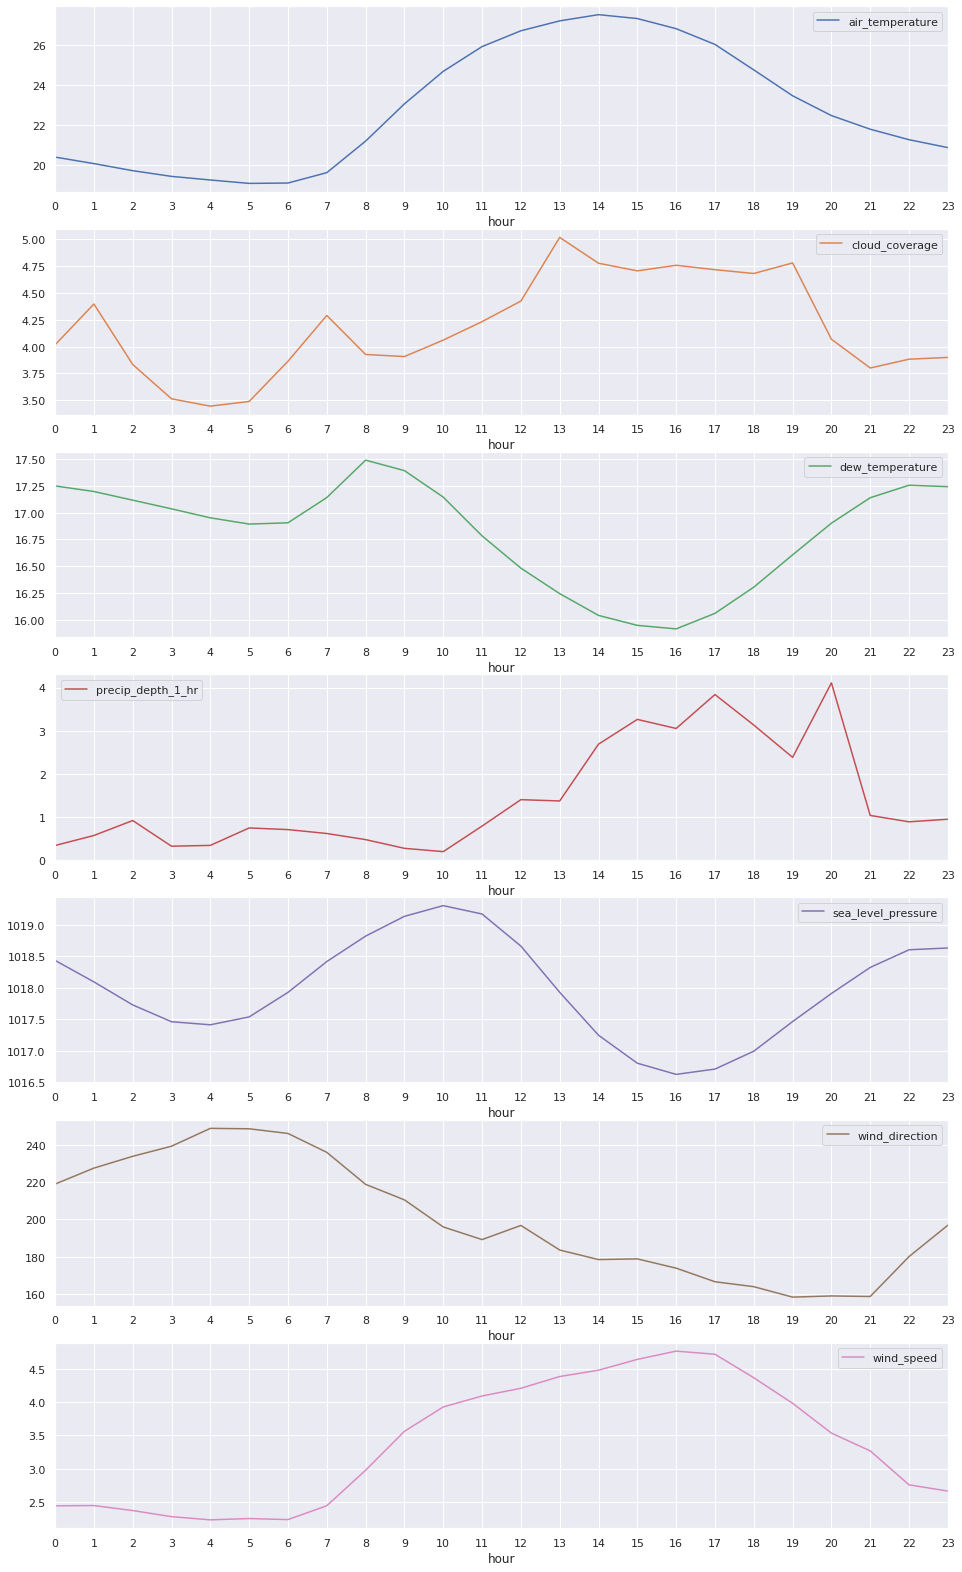

In [46]:
# Site 8 hourly weather
wthr8 = udf.get_site(weather, 8).groupby('hour').mean()
wthr8.plot(subplots=True, figsize=(16,28), sharex=False, xticks=range(24))

In [47]:
del wthr8
gc.collect()

51

In site 8 (on average):
- The `air_temperature` peaks at 2 PM (in the afternoon as it should)
- The `cloud_coverage` is highest between 1 and 7 PM
- The `dew_temperature` dips in the afternoon to evening, which makes sense because it is less humid during these hours
- On rainy days, it rains the most between 5 and 8 PM
- The `sea_level_pressure` oscillates throughout the day reaching its maximum at 10 AM and minimum at 4 PM
- The `wind_direction` is limited between 160 and 250 degrees, which is roughly in the south to southwest direction
- It gets the windiest around 4 PM

<a id='eda_metr'></a>
### Meter Analysis
[Back to 3. Exploratory Analysis](#eda)

##### Inspect the data

In [48]:
meter.describe()

site_id   building_id         meter  meter_reading
count  2.021610e+07  2.021610e+07  2.021610e+07   2.021610e+07
mean   7.992232e+00  7.992780e+02  6.624412e-01   1.969306e+03
std    5.099060e+00  4.269133e+02  9.309921e-01   1.532161e+05
min    0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00
25%    3.000000e+00  3.930000e+02  0.000000e+00   1.782620e+01
50%    9.000000e+00  8.950000e+02  0.000000e+00   7.431100e+01
75%    1.300000e+01  1.179000e+03  1.000000e+00   2.460000e+02
max    1.500000e+01  1.448000e+03  3.000000e+00   2.190470e+07

Although it was established that `timestamp`s for every hour in 2016 are present in the meter data, some buildings have more meters than others so these buildings would have more `timestamp`s. Some buildings may also be missing `timestamp`s.

##### Check the amount of `meter_reading`s for each building

Text(0, 0.5, 'Number of meter readings')

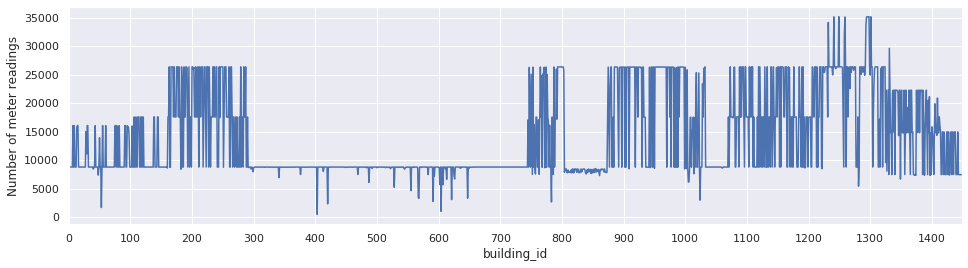

In [49]:
# Number meter readings each building has
meter.groupby('building_id').timestamp.count().plot()
plt.xticks(range(0, 1500, 100))
plt.ylabel('Number of meter readings')

Text(0, 0.5, 'Number of meters')

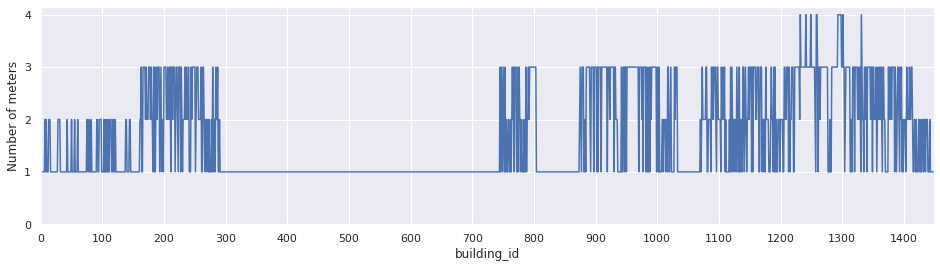

In [50]:
# Number of meters each building has
metrct = meter.groupby('building_id').meter.nunique()

metrct.plot()
plt.xticks(range(0, 1500, 100))
plt.yticks(range(5))
plt.ylabel('Number of meters')

Text(0.5, 0, 'Number of buildings')

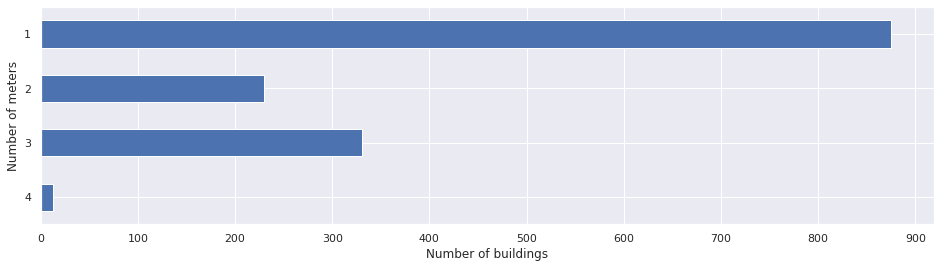

In [51]:
# Number of buildings that have n amount of meters
metrct.value_counts().sort_index(ascending=False).plot(kind='barh')
plt.xticks(range(0, 1000, 100))
plt.ylabel('Number of meters')
plt.xlabel('Number of buildings')

Text(0.5, 0, 'Number of buildings')

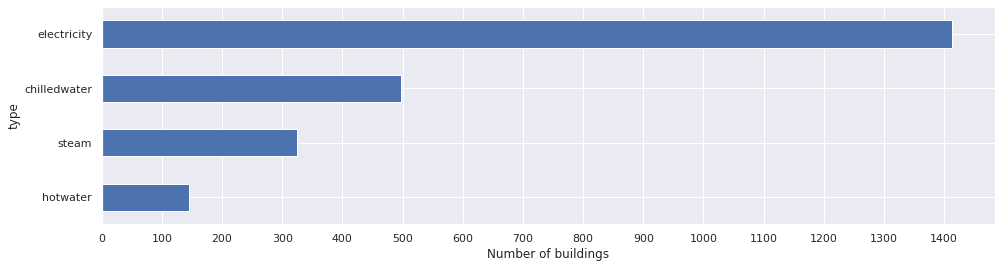

In [52]:
# Number of buildings that have each meter type
bldgct_bymetr = meter.groupby('type').building_id.nunique().sort_values()
bldgct_bymetr.plot(kind='barh')
plt.yticks(range(4))
plt.xticks(range(0, 1500, 100))
plt.xlabel('Number of buildings')

In [53]:
del metrct, bldgct_bymetr

Observations:
- Most of the buildings only have 1 type of meter and very few buildings actually have all 4 meter `type`s
- Almost all the buildings have an electricity meter
- A lot of buildings don't have `meter_reading`s for every hour

##### Check the number of meters missing measurements

In [54]:
udf.print_missing_readings(meter)

1085 different buildings (74%) have meters that are missing readings
A total of 1660 meters (69%) are missing readings

990 electricity meters (70%) are missing readings
347 chilledwater meters (69%) are missing readings
221 steam meters (68%) are missing readings
102 hotwater meters (70%) are missing readings


Every meter should have 8784 recorded readings (24 hours x 366 days). The majority of meters is actually missing `meter_reading`s. This may not be a problem since there are about 20 million records in the meter data. For now, the meter data will be left as is, but this is something important to note.

##### Time series analysis

##### Begin with the buildings that opened in 2016 and 2017

In [55]:
construct = building[building.in_construction == True]
construct

site_id  building_id                    primary_use  square_feet  \
28         0           28                         Office        52957   
45         0           45                         Retail        15304   
46         0           46                         Retail         9045   
99         0           99                         Office         2260   
103        0          103                      Education        21657   
363        3          363                      Education        69300   
409        3          409                      Education        38500   
567        4          567  Entertainment/public assembly        82670   

     year_built  floor_count  in_construction  
28         2016            2                1  
45         2016            1                1  
46         2016            1                1  
99         2016            1                1  
103        2016            1                1  
363        2017            3                1  
409        2016            2                1  
567        2016            4                1

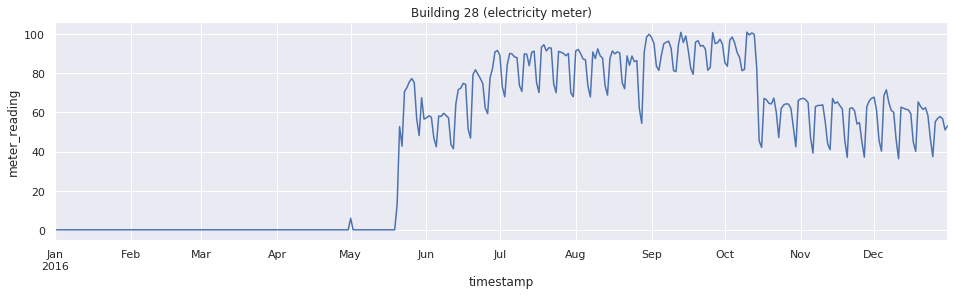

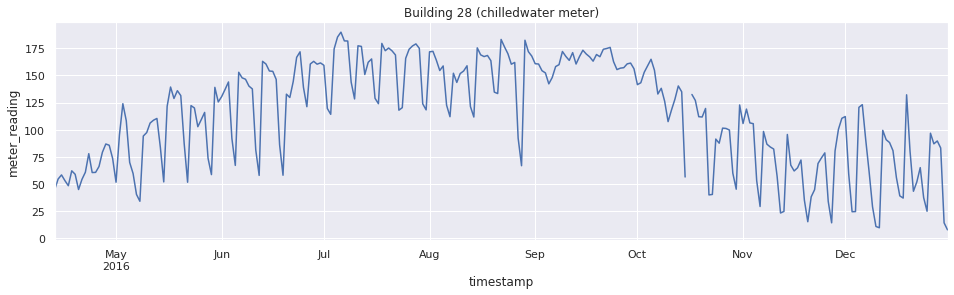

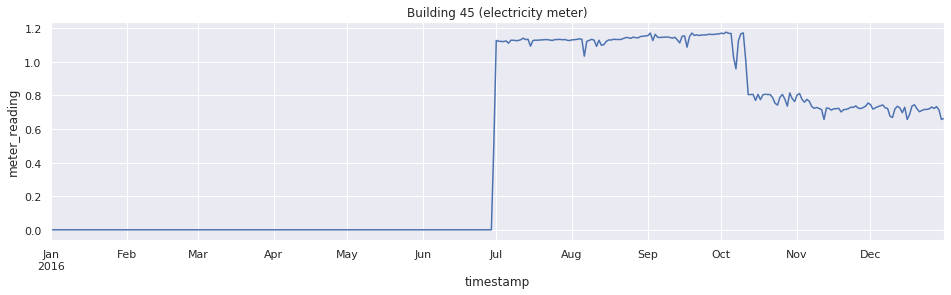

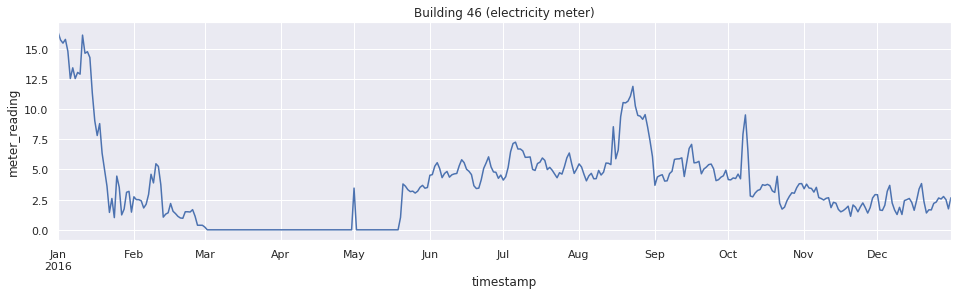

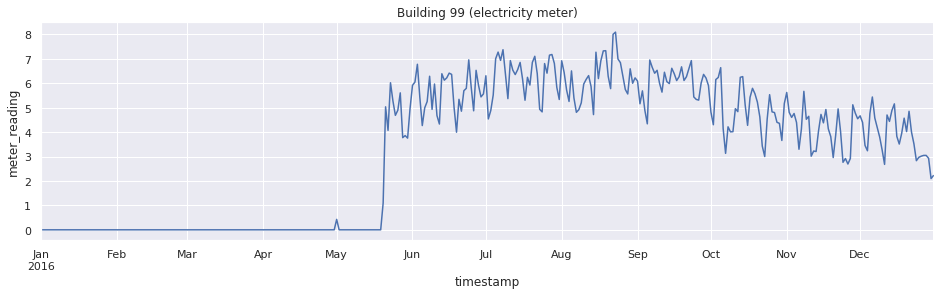

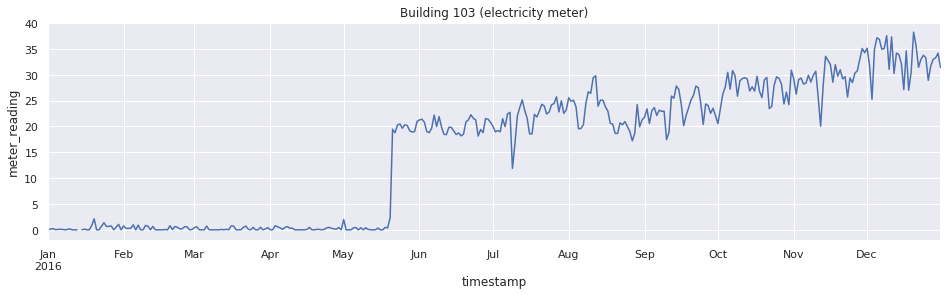

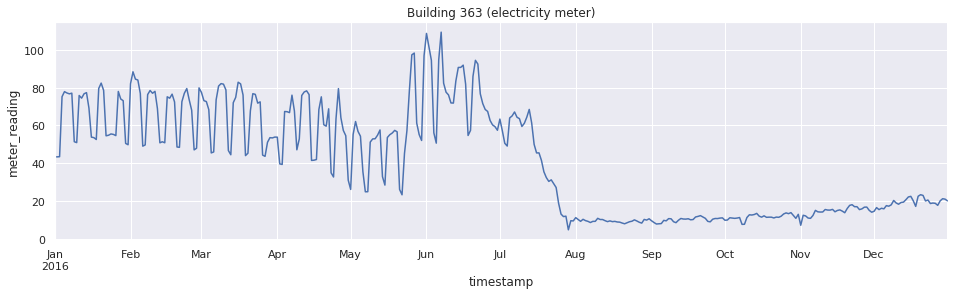

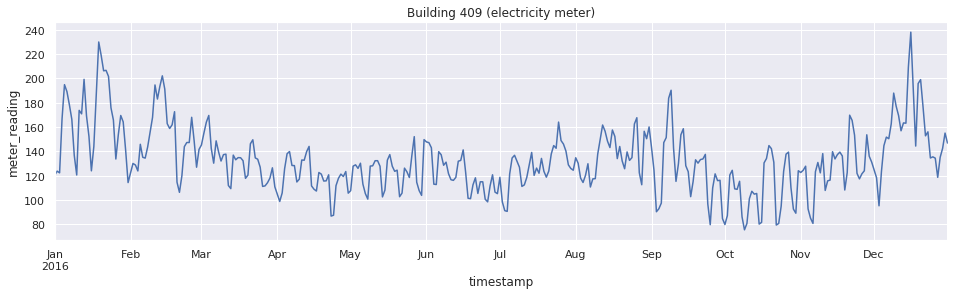

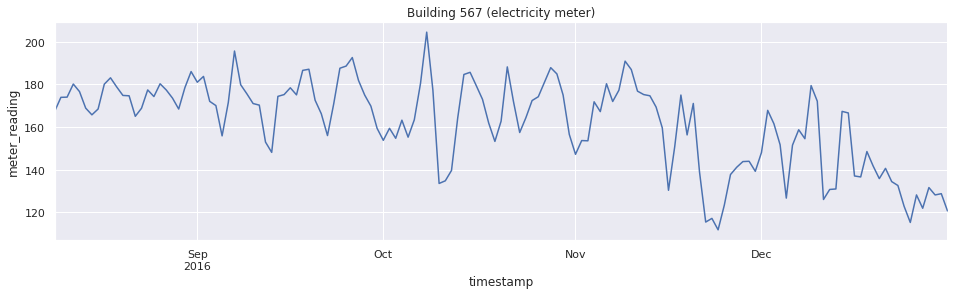

In [56]:
bldgs = construct.building_id
udf.plot_readings(meter, bldgs, reverse=True)

Electricity meters in the 2016/2017 buildings:
- All of these buildings have an electricity meter
- All the electricity meters from site 0 have a period of time stretching several months, where the meter readings stay around 0 (except for the outliers)
    - This could signify a period of non-operation or it could just be an error in data collection
- Buildings 28 and 45 show a similar drop in electricity usage in early to mid October, although there is a difference in scale
    - The scale difference (of about 100x) may mean the 2 buildings recorded the meter readings in different units
- Electricity usage in building 46 goes flat in March for 2 and a half months
- The electricity `meter_reading`s of buildings 45, 46, 99, and 103 are consistently low throughout the year
- Electricity usage in buildings 99 and 103 both increase from the 0 line in the middle of May
    - A possible explanation is that the 2 buildings are nearby and opened at the same time
- There's a big drop in electricity usage in building 363 in July and the usage stays relatively low for the rest of the year

Other observations:
- The scale for chilled water `meter_reading`s are much higher than the scale for electricity `meter_reading`s
- The chilled water usage is higher in the summer months in building 28, but this pattern is not as apparent in building 103
- There are outliers (likely errors) with 4 meters that cause a peak in an otherwise flat section of the plot
- There are dips that deviate from the general usage pattern in a few meters
- Buildings 28 and 103 are missing chilled water `meter_reading`s at the beginning of the year
- Building 567 from site 4 is missing electric `meter_reading`s from the first 7 months

It may be best to just remove these 8 buildings from the data.

##### Remove all buildings that opened in either 2016 or 2017

In [57]:
meter = meter[~(meter.building_id.isin(construct.building_id))]
meter.shape

(20137746, 6)

In [58]:
building.drop('in_construction', axis=1, inplace=True)
building.head()

site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432        2008            1
1        0            1   Education         2720        2004            1
2        0            2   Education         5376        1991            1
3        0            3   Education        23685        2002            1
4        0            4   Education       116607        1975            4

##### Plot the `meter_reading`s of each meter type by month

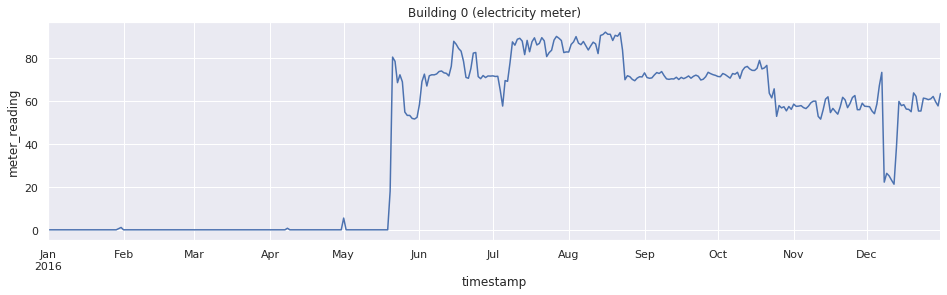

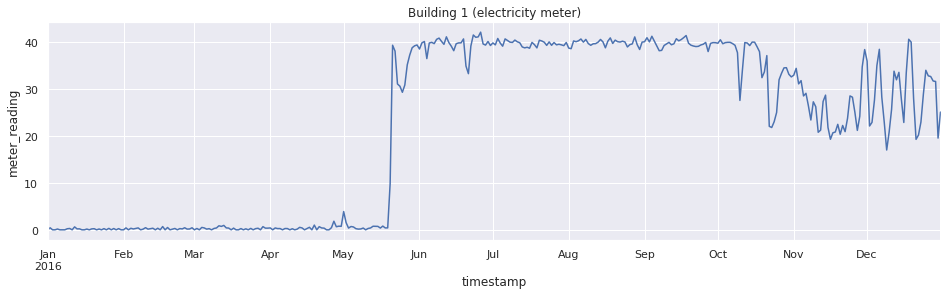

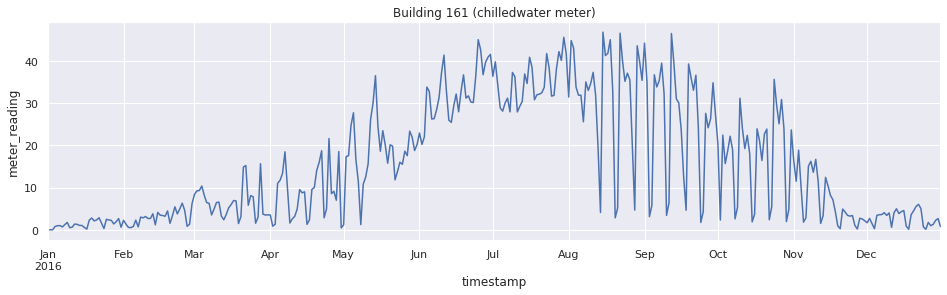

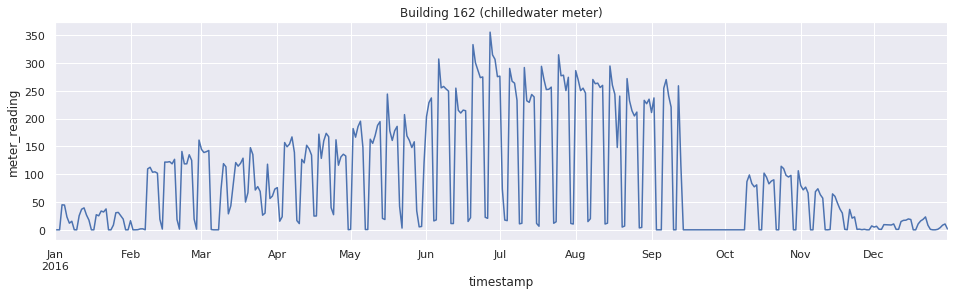

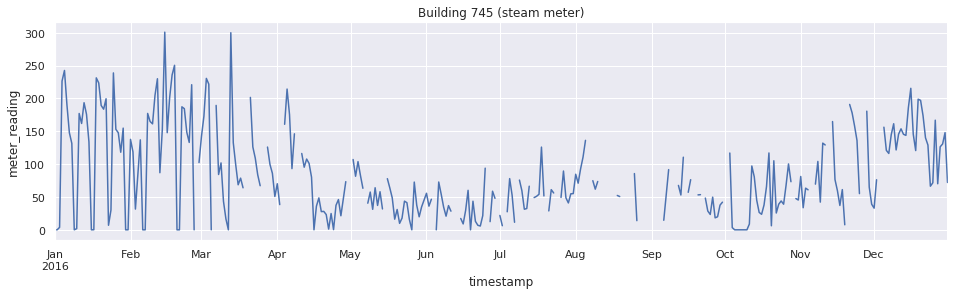

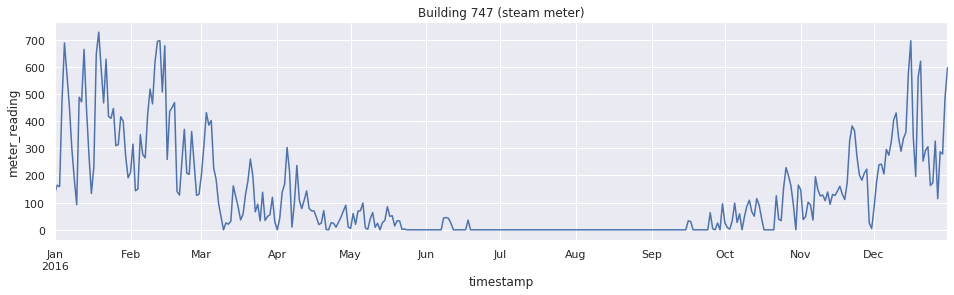

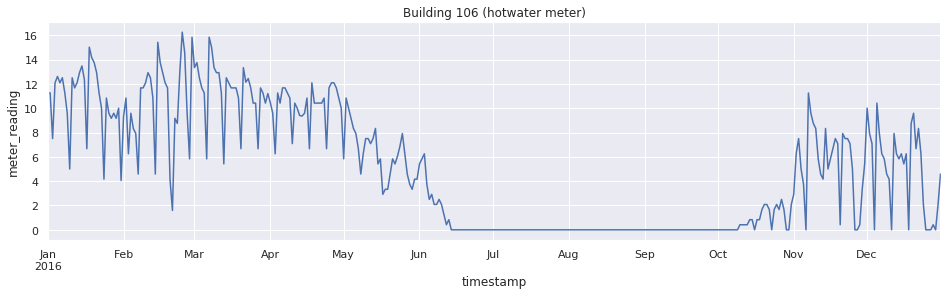

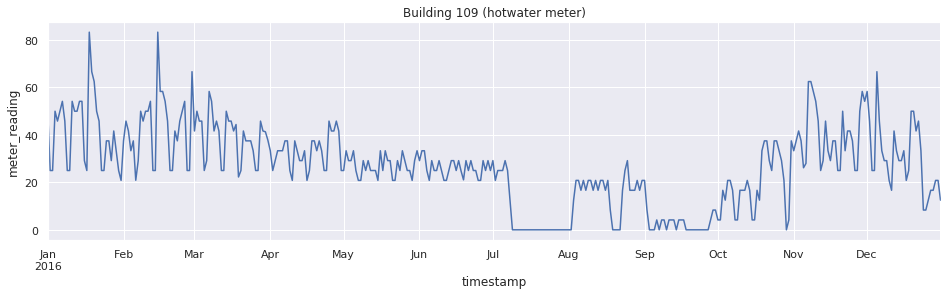

In [59]:
# Plot 2 of each meter
bldgs = [meter[meter.meter == m].building_id.unique() for m in range(4)]
udf.plot_readings(meter, bldgs, freq='d', start=0, end=2)

Electricity meters:
- Readings are at the 0 line from the beginning of the year to the middle of May
- Readings stay at a relatively constant level from mid-May to mid-October, where a slight drop occurs and again stays relatively constant for the rest of the year

Chilled water meters:
- Readings peak in the summer months as expected

Steam meters and hot water meters:
- Readings show the opposite pattern as chilled water meters (at the lowest in the summer months), which is also expected

There are also missing readings with some of these meters.

##### Plot the meter readings of each meter type by weekday

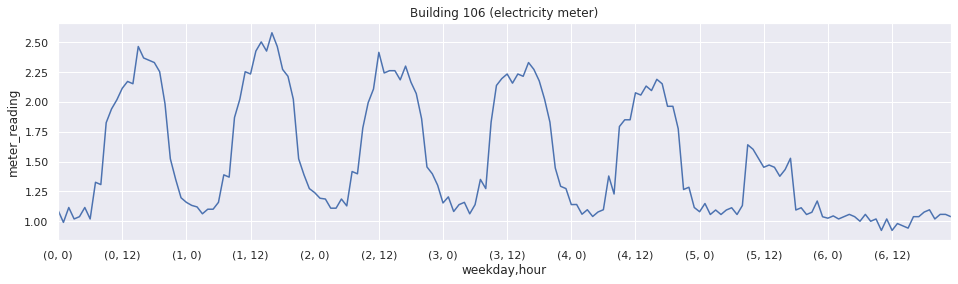

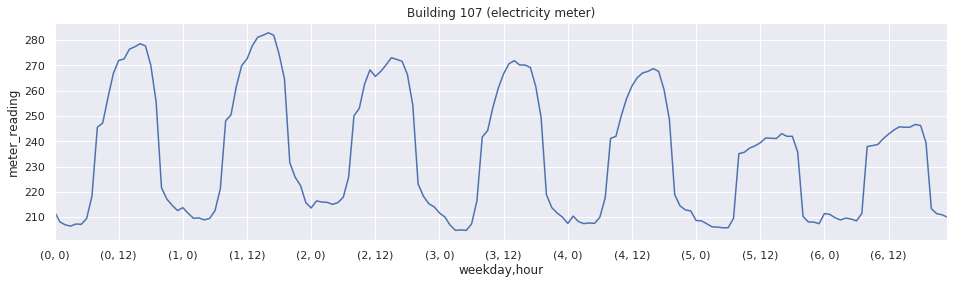

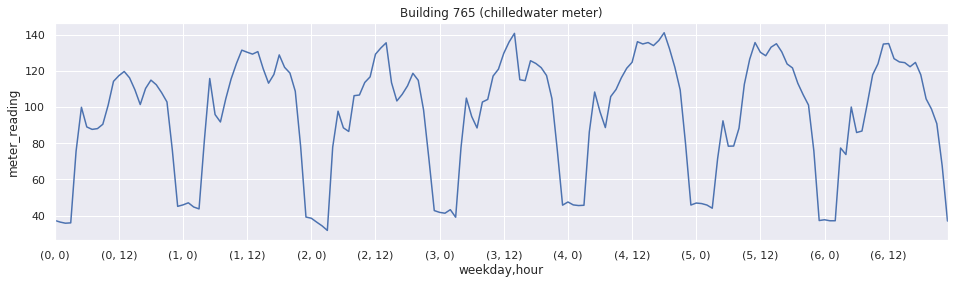

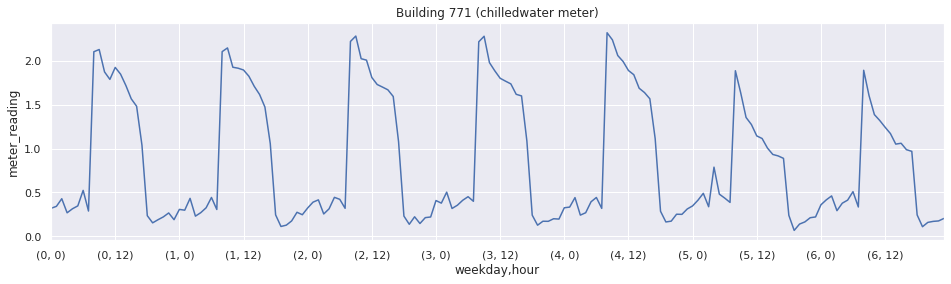

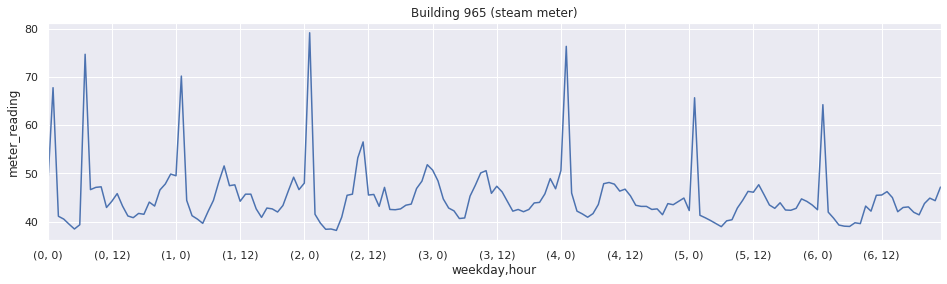

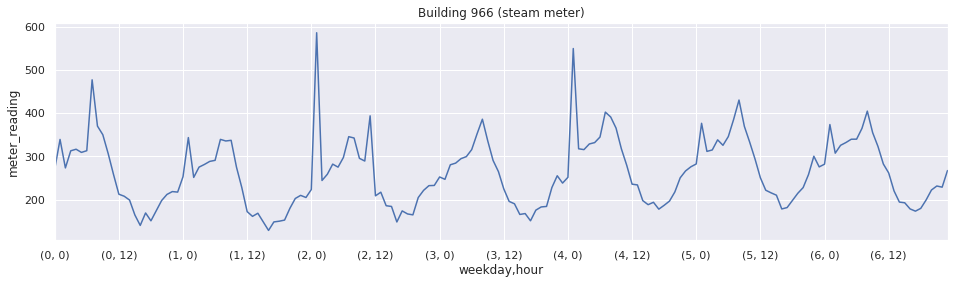

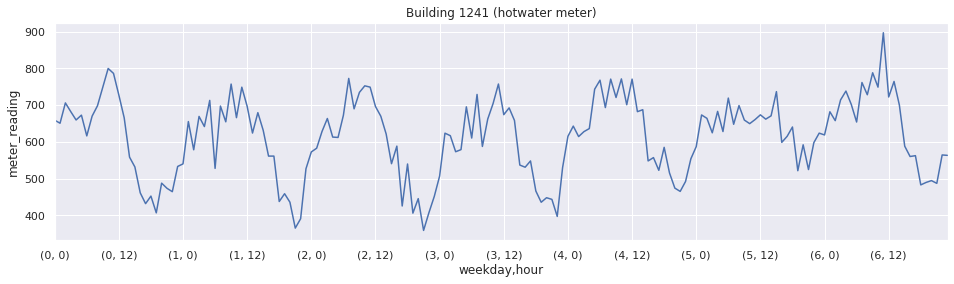

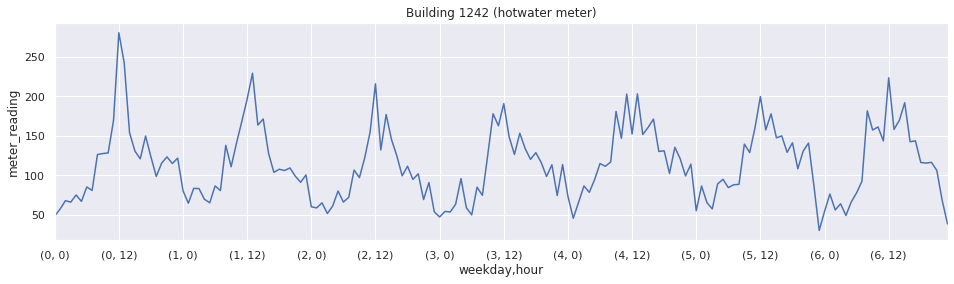

In [60]:
# Extract weekday and hour from the timestamp
meter['weekday'] = meter.timestamp.dt.dayofweek
meter['hour'] = meter.timestamp.dt.hour

# Plot 2 of each meter
udf.plot_readings(meter, bldgs, group=['weekday', 'hour'], start=99, end=101, ticks=range(0, 7 * 24, 12))

Electricity meters:
- Usage oscillates between day and night, peaking after noontime in the day
- Usage is lower on weekends

Chilled water meters:
- Usage shows a similar pattern as electricity meters, but usage doesn't decrease over the weekend in building 765 and only decreases a little in building 771
- Usage peaks before noon in building 771

Steam meters:
- Usage also oscillates between day and night, but most peaks occur around midnight

Hot water meters:
- Usage has the same pattern as chilled water meters with no decrease on weekends

##### Plot the meter readings of each meter type by hour

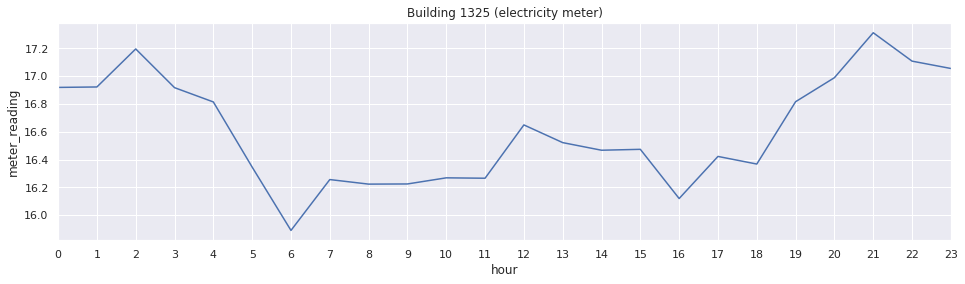

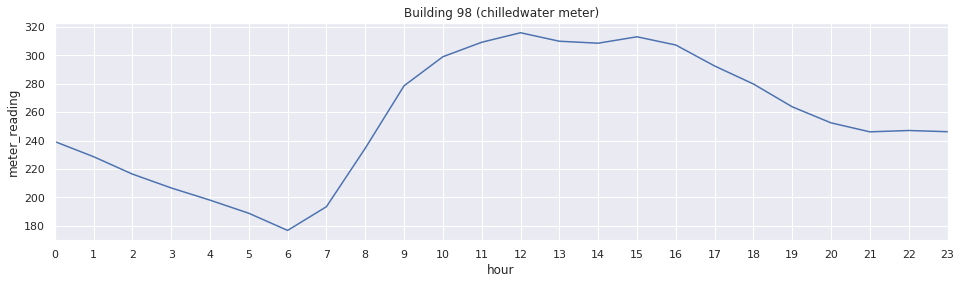

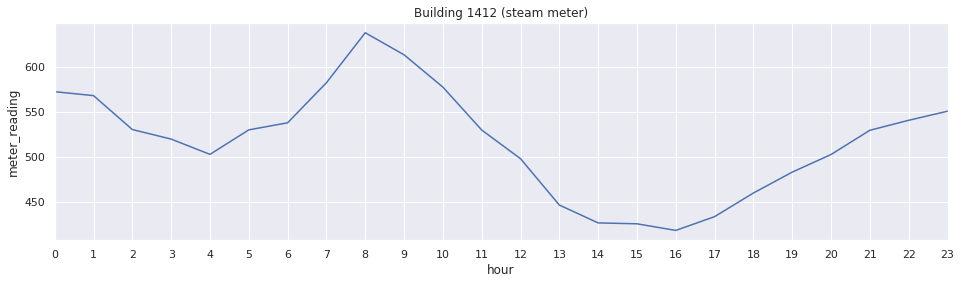

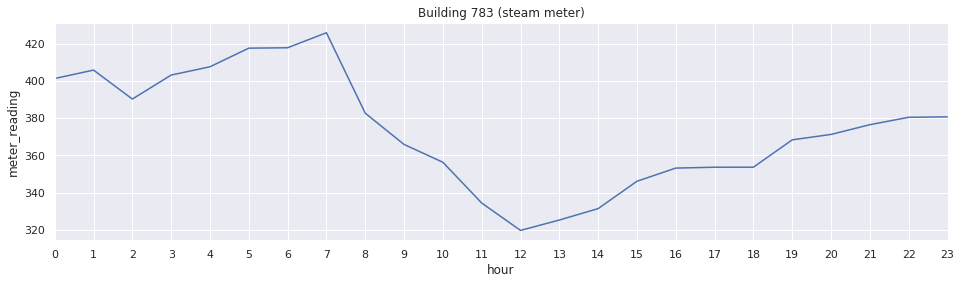

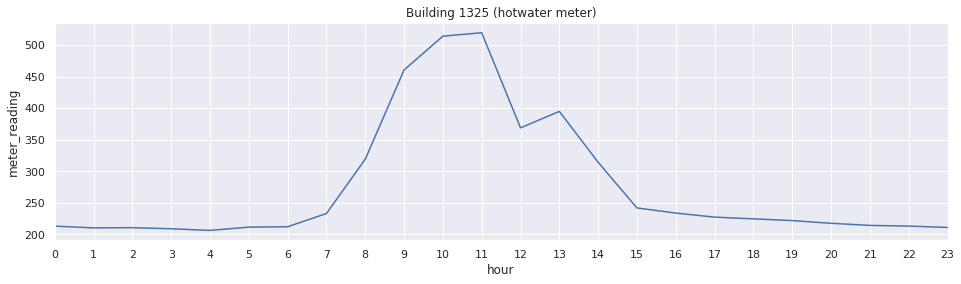

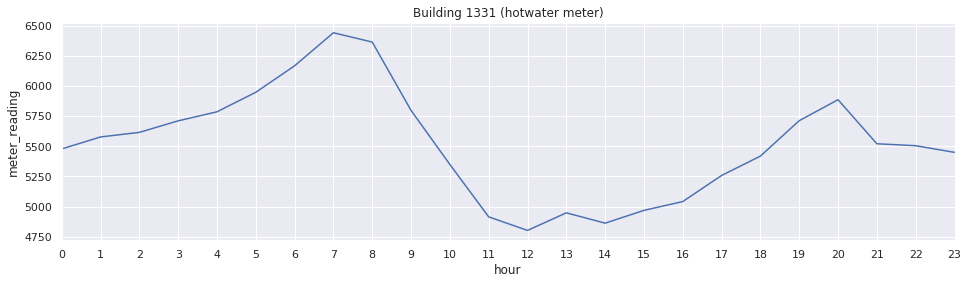

In [61]:
# Plot 2 of each meter
udf.plot_readings(meter, bldgs, group=['hour'], start=-3, end=-1, ticks=range(24))

In [62]:
del construct, bldgs
gc.collect()

26610

Building 1325 is showing an unexpected pattern, where the electricity usage is peaking at night. There may be a timezone difference in the meter data like there was with the weather data.

##### Check the average hourly electricity usage by site

In [63]:
site_byhr = meter[meter.type == 'electricity'].pivot_table(index='hour', columns='site_id', values='meter_reading', aggfunc='mean')
site_byhr

site_id         0           1           2           3           4          5   \
hour                                                                            
0        63.360119  143.420258  137.283173  106.031769  157.627380  19.669161   
1        62.298283  142.398682  135.757629  105.924370  155.958618  18.923874   
2        61.359440  140.066162  136.162735  106.380997  153.911057  18.801413   
3        60.547081  139.143631  135.821320  107.456833  152.806046  19.000902   
4        60.138332  138.907684  137.067474  110.239532  152.670410  19.182199   
5        60.895683  139.897415  142.140900  115.426582  155.345657  19.794270   
6        64.118095  144.347321  147.049133  123.525780  163.008987  23.055973   
7        67.662987  150.756805  149.762650  131.332535  173.392334  29.328558   
8        68.730698  159.344696  154.882553  137.490723  183.475479  35.556381   
9        70.372696  168.891266  160.288132  141.927017  193.975708  41.141666   
10       71.889153  177.120697  163.432098  144.213928  200.545364  45.478638   
11       72.907921  182.839371  165.178726  144.912643  205.565491  48.020145   
12       74.222305  186.058441  166.567535  145.025772  207.588684  47.937119   
13       74.784805  187.300644  167.272034  144.719315  210.072769  46.539227   
14       74.831123  187.374451  167.046127  143.596542  210.105392  45.471401   
15       74.660606  187.468735  166.685333  141.657059  209.506546  43.621460   
16       74.208244  186.059875  164.582809  138.777618  206.883347  39.511829   
17       73.233879  182.408798  160.309799  135.109863  199.603119  34.821793   
18       73.223778  176.034470  157.516464  129.110458  192.808487  32.178886   
19       73.730774  168.463470  156.202591  123.436569  186.627838  29.712210   
20       72.645103  159.545853  153.984833  119.915039  180.192139  27.008488   
21       72.132027  153.969788  149.937271  115.013863  172.225143  24.162508   
22       70.202606  149.489685  146.637711  110.454842  164.517471  21.951727   
23       65.708138  145.545303  141.227798  107.369904  160.863586  20.302452   

site_id          6            7          8           9          10  \
hour                                                                 
0        156.827515  1610.026367  65.656799  163.520844  61.564274   
1        154.066422  1602.389893  65.677094  184.159851  62.753059   
2        151.233795  1601.391602  65.758759  154.859085  61.290009   
3        149.168289  1613.572510  65.720970  152.405136  60.973156   
4        149.293030  1710.468384  65.724747  151.101959  60.901524   
5        153.328796  1983.812500  65.736176  152.069061  65.902046   
6        162.070892  2228.479492  65.732796  155.902512  83.366493   
7        172.073914  2355.019287  65.737541  171.350266  81.212097   
8        180.763229  2413.288086  65.767853  177.029892  87.928802   
9        188.295670  2434.108154  65.786171  182.759125  94.242317   
10       193.505478  2448.158936  65.810356  191.396530  95.821953   
11       195.465836  2458.584229  65.832115  196.851089  96.919083   
12       196.232864  2458.184326  65.855827  197.855423  96.714806   
13       198.629257  2451.295654  65.857864  201.091293  96.691833   
14       198.750778  2439.389160  65.865257  201.604523  96.264671   
15       196.757431  2378.451416  65.857193  202.772903  94.624382   
16       194.218018  2289.515137  65.733597  199.684753  91.697762   
17       188.208832  2075.123291  65.677666  196.269913  87.644585   
18       183.165253  1903.539307  65.672714  190.191330  85.776588   
19       180.225052  1806.832275  65.661400  187.251373  82.804604   
20       178.535187  1755.244629  65.654640  183.420822  79.735527   
21       175.430649  1702.010742  65.646072  180.521866  73.056465   
22       170.880753  1657.922363  65.642578  176.022186  67.821510   
23       164.263443  1628.002686  65.641617  169.852921  64.163361   

site_id          11          12          13          14          15  
ho

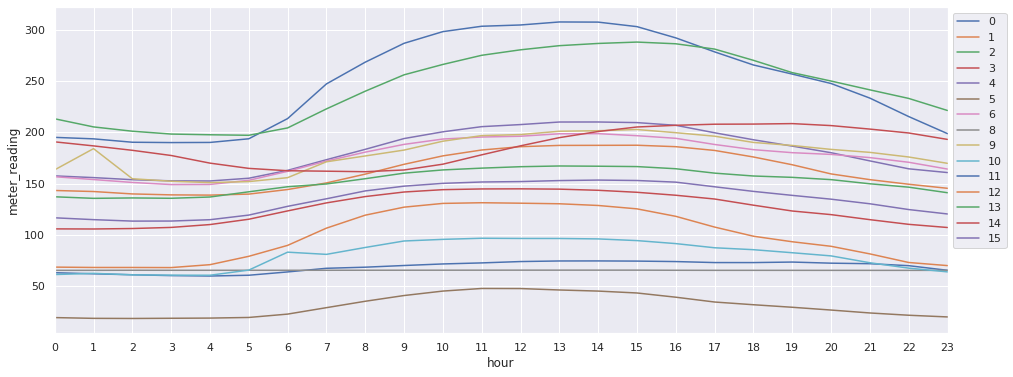

In [64]:
site_byhr.drop(7, axis=1).plot(figsize=(16, 6), xticks=range(24))
plt.ylabel('meter_reading')
plt.legend(bbox_to_anchor=(1, 1))

Text(0.5, 1.0, 'Site 7 electricity meter')

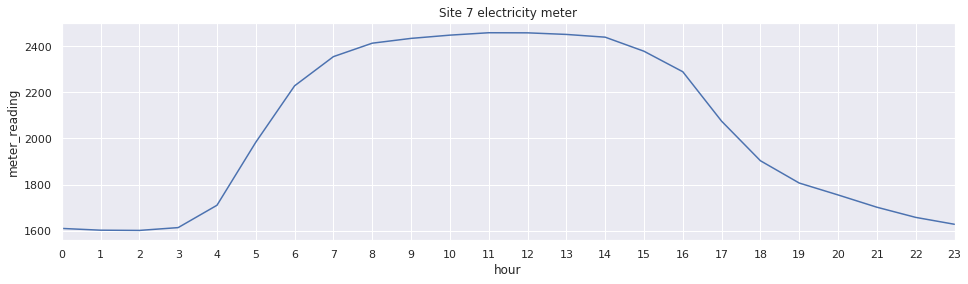

In [65]:
# The scale of site 7 is much larger
site_byhr[7].plot(xticks=range(24))
plt.ylabel('meter_reading')
plt.title('Site 7 electricity meter')

It doesn't look like the meter was recorded in UCT after all.

In [66]:
del site_byhr
gc.collect()

1171

##### Plot the average electricity `meter_reading`s by site

site_id             0           1           2           3           4   \
timestamp                                                                
2016-01-01    0.096517  130.895172  130.235382  107.390465  154.542831   
2016-01-02    0.250731  131.021683  133.014725  106.557686  152.769745   
2016-01-03    0.624257  131.264633  130.550095  103.839539  162.714325   
2016-01-04    0.149355  153.480148  147.911758  133.670670  181.021149   
2016-01-05    0.060936  156.681183  149.458618  143.390198  181.918594   
...                ...         ...         ...         ...         ...   
2016-12-27   99.060966  126.964943  130.821594  108.374466  147.573471   
2016-12-28   97.903839  132.405273  138.591064  104.720497  149.355438   
2016-12-29   98.890327  132.336853  138.665771  109.423218  150.217667   
2016-12-30  101.603134  131.736649  135.669479  111.240082  149.317200   
2016-12-31  101.254242  124.520317  125.807404   99.834084  142.658691   

site_id            5           6            7          8           9   \
timestamp                                                               
2016-01-01  21.133106  150.683929  1784.532715  65.234848  130.623734   
2016-01-02  23.323677  160.404236  1671.163208  67.465805  139.397552   
2016-01-03  22.021584  163.670959  1633.909668  61.591049  134.341553   
2016-01-04  36.395508  184.680084  2176.916504  59.245579  156.081787   
2016-01-05  38.388134  192.533997  2206.263428  52.291134  161.371490   
...               ...         ...          ...        ...         ...   
2016-12-27  23.760166  159.497803  2079.382080  64.021149  153.807510   
2016-12-28  27.761290  165.084152  2605.366211  64.483528  147.691010   
2016-12-29  28.427103  166.437210  2618.556885  77.346100  146.260010   
2016-12-30  27.986423  160.724594  2561.065918  64.763252  146.685883   
2016-12-31  23.116076  155.196625  1831.076782  58.962494  144.143341   

site_id            10          11          12          13          14  \
timestamp                                                               
2016-01-01  71.033676  197.078125   77.931694  182.164764  166.050903   
2016-01-02  75.223228  197.901047  118.952515  183.805908  170.267502   
2016-01-03  70.096931  196.187500  123.468552  181.031082  170.302750   
2016-01-04  85.848412  235.473953  114.252876  209.805740  189.176422   
2016-01-05  84.937775  238.328125   72.763870  211.803040  197.860458   
...               ...         ...         ...         ...         ...   
2016-12-27  80.725098  167.967697   67.867210  217.103836  177.955276   
2016-12-28  77.387787  169.517715   69.536491  216.928589  182.645020   
2016-12-29  76.479240  166.553391   71.057510  216.972534  183.934586   
2016-12-30  70.554047  166.117966   72.515648  214.679993  177.271790   
2016-12-31  72.222351  161.700790   66.222115  191.142426  171.618546   

site_id             15  
timestamp               
2016-01-01  116.749664  
2016-01-02  117.481873  
2016-01-03  118.852905  
2016-01-04  134.948334  
2016-01-05  136.744919  
...                ...  
2016-12-27  109.511261  
2016-12-28  111.286530  
2016-12-29  111.046921  
2016-12-30  111.928101  
2016-12-31  110.708878  

[366 rows x 16 columns]

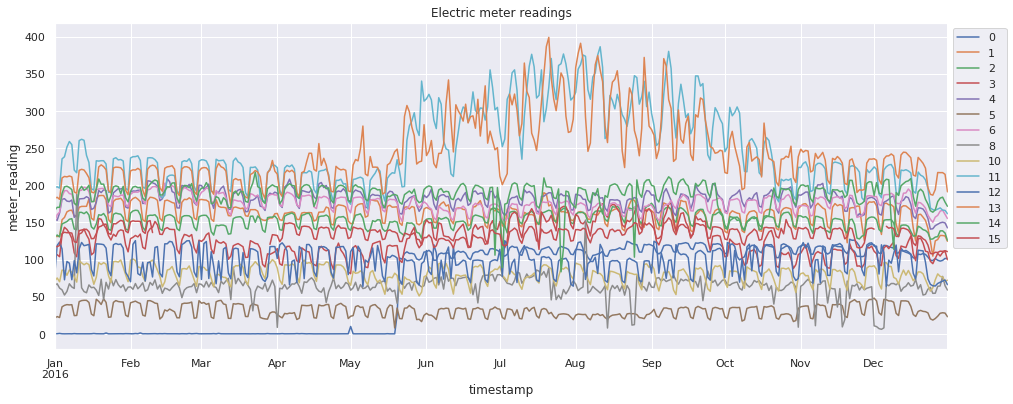

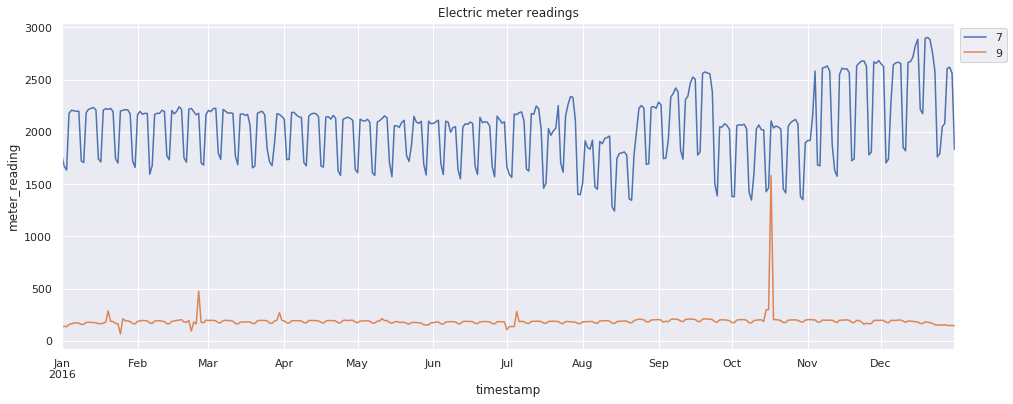

In [67]:
# Electric meters only
e_meter = meter[meter.meter == 0].drop(['meter', 'type'], axis=1)

# Electric meter readings by site
udf.show_elec_readings(e_meter, by='site_id', freq='d', cols_to_sep=[7, 9])

Average electricity meter readings by site:
- A lot, if not all, of buildings in site 0 have meter readings of 0 from the beginning of the year to the middle of May
- Electricity usage in sites 11 and 13 peak during the summer, while it stays relatively constant throughout the year in all other sites
- Electric usage in site 5 is much lower than the others and usage in site 7 is much higher than the others
- There's a huge outlier during October in site 9 that could be an error
- Site 15 is missing `meter_reading`s in February and March

##### Explore the meter data in relation to the building data

In [68]:
# Encode primary_use into integers
encoder = LabelEncoder()
building['use_encoded'] = encoder.fit_transform(building.primary_use).astype('uint8')

# Extract columns to be used
bldg = building[['building_id', 'use_encoded', 'primary_use', 'year_built', 'square_feet', 'floor_count']]

# Merge the dataframes
metr_bldg = pd.merge(meter, bldg, on='building_id', how='left')

# Electric meters only
e_meter = metr_bldg[metr_bldg.type == 'electricity'].drop(['meter', 'type'], axis=1)
e_meter.head()

site_id  building_id  timestamp  meter_reading  weekday  hour  use_encoded  \
0        0            0 2016-01-01            0.0        4     0            0   
1        0            1 2016-01-01            0.0        4     0            0   
2        0            2 2016-01-01            0.0        4     0            0   
3        0            3 2016-01-01            0.0        4     0            0   
4        0            4 2016-01-01            0.0        4     0            0   

  primary_use  year_built  square_feet  floor_count  
0   Education        2008         7432            1  
1   Education        2004         2720            1  
2   Education        1991         5376            1  
3   Education        2002        23685            1  
4   Education        1975       116607            4

year_bin    1899 - 1909  1909 - 1919  1919 - 1928  1928 - 1938  1938 - 1947  \
timestamp                                                                     
2016-01-01   121.621468    32.451256   155.969711   101.398750    97.497292   
2016-01-02   119.941292    33.477684   153.613998    94.756950    97.151222   
2016-01-03   118.283661    34.670742   145.618973   101.638206    96.996948   
2016-01-04   142.185333    48.149437   187.661774   121.366280   122.671997   
2016-01-05   145.737656    50.493839   198.730042   123.699944   128.843781   
...                 ...          ...          ...          ...          ...   
2016-12-27   121.176285    33.397331   135.927216   100.468857   104.362976   
2016-12-28   119.757988    36.701653   134.386032   102.880653    96.388451   
2016-12-29   121.858406    37.525887   136.025238   103.769608   100.579689   
2016-12-30   120.522804    38.220478   138.708038   107.504616   100.773323   
2016-12-31   114.953148    35.324497   131.845596    95.011391    95.059677   

year_bin    1947 - 1957  1957 - 1967  1967 - 1976  1976 - 1986  1986 - 1995  \
timestamp                                                                     
2016-01-01   210.191589   136.583481   106.111443   153.542572   206.321976   
2016-01-02   203.365814   142.748718   106.659256   153.295578   207.317780   
2016-01-03   203.711273   141.067139   103.656746   155.412735   207.764648   
2016-01-04   248.708252   161.052307   127.378815   195.371902   237.402283   
2016-01-05   252.092682   161.762238   130.501480   206.747299   242.604797   
...                 ...          ...          ...          ...          ...   
2016-12-27   184.819046   139.770844   138.601730   157.881256   231.573990   
2016-12-28   209.782837   141.567520   147.487747   179.839447   244.989090   
2016-12-29   210.393631   143.351593   149.573883   180.553040   247.528351   
2016-12-30   209.092484   140.727798   145.932434   180.500946   244.805420   
2016-12-31   187.673523   132.737671   122.063820   149.654114   223.659683   

year_bin    1995 - 2005  2005 - 2015  
timestamp                             
2016-01-01    54.768349   202.994507  
2016-01-02    55.379967   200.065918  
2016-01-03    54.670670   199.348419  
2016-01-04    61.997517   232.484970  
2016-01-05    62.830421   241.898209  
...                 ...          ...  
2016-12-27    98.980064   235.666412  
2016-12-28    98.043114   237.540192  
2016-12-29    98.398987   240.784149  
2016-12-30   101.694687   241.743546  
2016-12-31    98.674721   224.444077  

[366 rows x 12 columns]

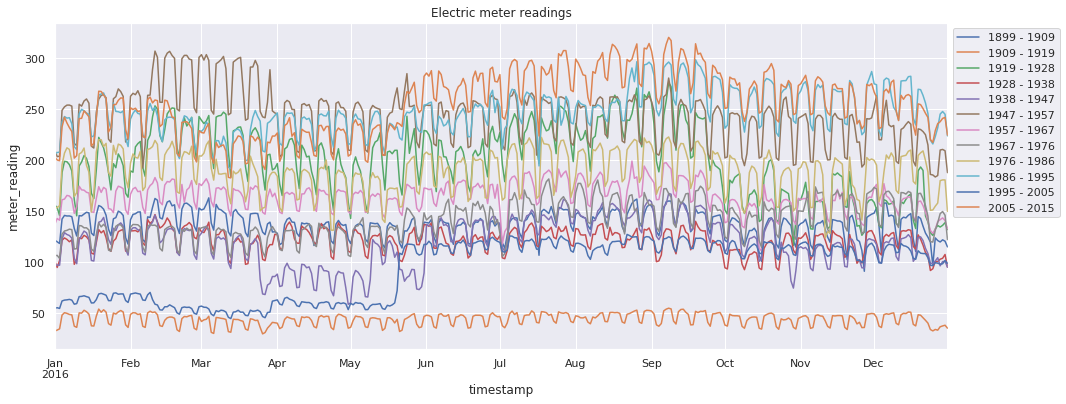

In [69]:
# Bin year_built
e_meter['year_bin'] = pd.cut(e_meter.year_built, bins=12)

# Rename bins
e_meter.year_bin = e_meter.year_bin.apply(lambda y: f'{int(y.left)} - {int(y.right)}')

# Electric meter readings by year built
udf.show_elec_readings(e_meter, by='year_bin', freq='d')

In [70]:
# Electric meter readings by primary use
udf.show_elec_readings(e_meter, by='primary_use', freq='d', legend_pos=(0.9, -0.2), legend_col=4)

primary_use   Education  Entertainment/public assembly  \
timestamp                                                
2016-01-01   191.499374                      85.596504   
2016-01-02   191.513809                      96.491936   
2016-01-03   190.296509                      93.125786   
2016-01-04   227.763962                      96.145775   
2016-01-05   230.804520                      94.447968   
...                 ...                            ...   
2016-12-27   210.171768                      98.523674   
2016-12-28   223.809036                      99.319214   
2016-12-29   224.800049                     104.233620   
2016-12-30   223.175629                      99.113098   
2016-12-31   199.264816                      93.585075   

primary_use  Food sales and service  Healthcare  Lodging/residential  \
timestamp                                                              
2016-01-01                57.775269  252.617203            54.889503   
2016-01-02                56.004456  254.700851            55.898479   
2016-01-03                55.678207  252.124695            54.641193   
2016-01-04                65.751213  283.154022            58.558826   
2016-01-05                69.037048  297.571045            62.690994   
...                             ...         ...                  ...   
2016-12-27                66.166473  282.181274            66.862541   
2016-12-28                65.802650  284.866333            67.347977   
2016-12-29                65.895714  285.059937            67.900986   
2016-12-30                65.656845  287.958099            68.011917   
2016-12-31                62.774967  273.846588            68.120064   

primary_use  Manufacturing/industrial      Office      Other    Parking  \
timestamp                                                                 
2016-01-01                  76.058975  115.350121  36.339516  42.593391   
2016-01-02                  87.069824  115.346275  36.163048  43.160042   
2016-01-03                  87.500557  113.910797  35.471798  42.704491   
2016-01-04                  96.065186  144.028381  36.192486  44.970306   
2016-01-05                  97.545601  148.179092  38.081638  45.856644   
...                               ...         ...        ...        ...   
2016-12-27                 102.023422  134.363922  45.528255  52.947685   
2016-12-28                 103.706093  133.437576  45.282501  52.108021   
2016-12-29                 108.344124  135.016281  45.466145  51.862907   
2016-12-30                 108.935448  132.589813  45.906212  51.768871   
2016-12-31                  93.434578  115.735748  44.791695  49.902298   

primary_use  Public services  Religious worship     Retail   Services  \
timestamp                                                               
2016-01-01         80.129852           3.547153  18.020487  57.391514   
2016-01-02         82.644180           3.206805  28.480412  59.183315   
2016-01-03         82.307068           3.979583  30.613329  57.660202   
2016-01-04         96.434464           4.500556  29.830788  63.199398   
2016-01-05        100.895615           4.402709  20.724955  63.557858   
...                      ...                ...        ...        ...   
2016-12-27         80.848763           3.360625  73.284439  77.148865   
2016-12-28         82.582634           2.889444  68.801872  77.769302   
2016-12-29         85.189537           3.483056  70.038193  76.962059   
2016-12-30         84.514595           3.537986  69.000420  76.480492   
2016-12-31         78.748474           3.238264  67.188095  71.266876   

primary_use  Technology/science     Utility  Warehouse/storage  
timestamp                                                       
2016-01-01            77.231125   85.041168          43.744831  
2016-01-02            82.299454  108.146927          44.119267  
2016-01-03            80.178719   84.347191          40.700291  
2016-01-04            93.097458  118.440781          49.3

primary_use    Education  Entertainment/public assembly  \
weekday hour                                              
0       0     196.207718                      91.271790   
        1     199.071411                      92.209259   
        2     194.131424                      87.730972   
        3     194.235641                      87.002861   
        4     199.145126                      87.616203   
...                  ...                            ...   
6       19    210.408905                     109.190216   
        20    207.660843                     108.011856   
        21    204.565613                     104.734718   
        22    201.456848                      99.907410   
        23    198.177658                      95.527565   

primary_use   Food sales and service  Healthcare  Lodging/residential  \
weekday hour                                                            
0       0                  97.004433  279.276581            84.729111   
        1                  83.892792  278.015167            84.247627   
        2                  72.538979  275.975433            76.427116   
        3                  68.750313  274.258911            73.385765   
        4                  70.956856  272.354279            71.715714   
...                              ...         ...                  ...   
6       19                116.567085  289.621307            93.408127   
        20                110.109367  287.995697            92.960808   
        21                104.024582  287.474426            92.230339   
        22                 99.930412  285.030609            90.787163   
        23                100.119171  281.619781            88.151451   

primary_use   Manufacturing/industrial      Office      Other    Parking  \
weekday hour                                                               
0       0                    61.803600  123.111450  39.027328  42.295918   
        1                    55.815136  123.354736  39.153103  41.788727   
        2                    54.773514  122.251930  39.150162  41.673603   
        3                    57.420322  122.263489  39.258045  41.494301   
        4                    60.839901  123.692741  39.530170  41.373753   
...                                ...         ...        ...        ...   
6       19                   89.093094  130.989471  42.818897  40.236778   
        20                   90.624939  129.872421  41.778427  41.516792   
        21                   83.283966  128.453415  41.261585  42.601288   
        22                   81.709312  126.663971  40.691540  42.732277   
        23                   67.451118  124.108963  39.937679  42.663857   

primary_use   Public services  Religious worship     Retail   Services  \
weekday hour                                                             
0       0           88.807083           3.195473  50.294434  91.196373   
        1           86.445236           3.075135  49.589802  92.596680   
        2           84.987732           3.111712  49.319744  90.691048   
        3           84.271263           3.026115  48.683914  90.683159   
        4           83.562408           3.137466  51.805233  90.542557   
...                       ...                ...        ...        ...   
6       19          96.039825           4.367568  66.867691  85.840607   
        20          95.215416           4.602230  61.804268  88.194473   
        21          93.719612           4.663108  59.003033  91.089340   
        22          91.730652           4.575406  53.526337  91.855667   
        23          90.273285           3.533108  51.646358  91.701508   

primary_use   Technology/science     Utility  Warehouse/storage  
weekday hour                                                     
0       0              94.642067  241.272141          46.853474  
        1              94.824768  230.983322          45.896481  
        2              94.833382  221.662231          45.540424  


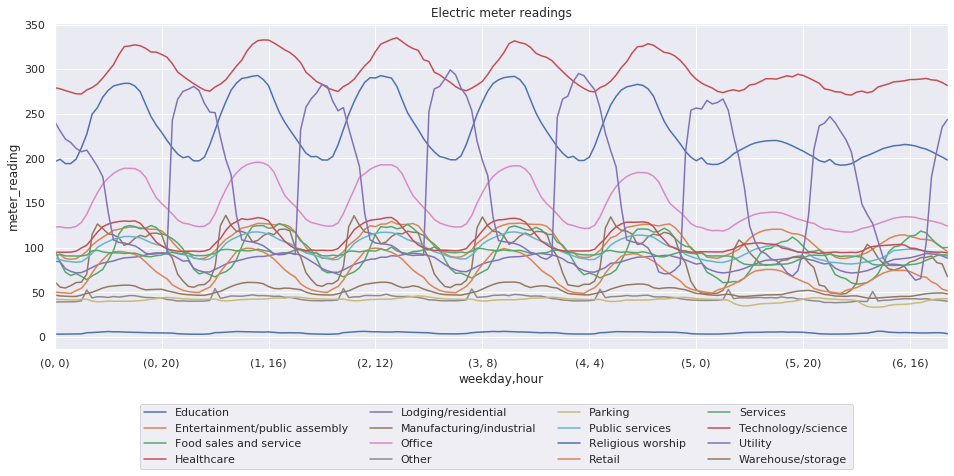

In [71]:
# Electric meter readings by primary use (weekday)
udf.show_elec_readings(e_meter, by='primary_use', idx=['weekday', 'hour'], legend_pos=(0.9, -0.15), legend_col=4)

floor_count         1          2           3           4           5   \
timestamp                                                               
2016-01-01   32.022156  50.183445  101.271469  117.811394  219.851837   
2016-01-02   33.451046  52.156811  102.974823  124.108658  217.229111   
2016-01-03   31.679157  51.892334  101.702202  125.381416  214.449463   
2016-01-04   34.623013  62.472523  123.625275  146.077026  257.775269   
2016-01-05   34.389275  63.774090  127.528435  143.048538  263.426666   
...                ...        ...         ...         ...         ...   
2016-12-27   38.174469  59.464439   93.932610  137.505569  235.069016   
2016-12-28   38.275425  60.858101   95.469208  138.694138  255.565628   
2016-12-29   40.863094  60.985069   96.008812  140.316315  253.288620   
2016-12-30   38.464935  60.042412   96.374176  139.881775  251.179214   
2016-12-31   36.462425  56.530724   88.683350  129.951065  231.595596   

floor_count          6           7           8           9           10  ...  \
timestamp                                                                ...   
2016-01-01   255.779022  261.198700  299.283813  426.503387  408.430939  ...   
2016-01-02   252.332977  264.357513  306.526123  434.069977  406.871368  ...   
2016-01-03   253.708893  266.545776  307.207703  429.176575  403.317169  ...   
2016-01-04   293.939606  295.629456  344.445465  516.893982  441.935852  ...   
2016-01-05   296.122620  298.961945  348.672272  525.479004  435.553925  ...   
...                 ...         ...         ...         ...         ...  ...   
2016-12-27   258.319519  280.356049  318.581421  444.336548  423.277679  ...   
2016-12-28   270.754608  281.348145  323.542389  451.700623  419.496338  ...   
2016-12-29   270.534241  284.810364  325.759277  454.637939  425.747742  ...   
2016-12-30   270.339691  285.137482  325.063202  448.116211  422.001099  ...   
2016-12-31   253.931244  268.552460  313.618713  402.409271  406.883789  ...   

floor_count           14          15          16          17          18  \
timestamp                                                                  
2016-01-01    989.894470  333.011963  196.445831  355.218903  816.774414   
2016-01-02    997.820984  361.331787  314.568756  357.145721  822.562561   
2016-01-03    987.949890  360.598114  246.806244  351.408173  820.711670   
2016-01-04   1084.777832  426.900299  252.337494  383.551727  948.259705   
2016-01-05   1093.231812  501.358856  354.725006  398.633331  951.415161   
...                  ...         ...         ...         ...         ...   
2016-12-27    872.110413  396.935486  353.845825  343.195343  853.583557   
2016-12-28    878.348877  392.052490  382.116669  343.303986  758.868774   
2016-12-29    974.454346  395.217377  338.972931  353.072357  750.582336   
2016-12-30    970.219299  418.417847  233.054169  359.604492  765.999023   
2016-12-31    956.520203  402.713959  235.947922  339.739136  691.220825   

floor_count           19           21          23          25           26  
timestamp                                                                   
2016-01-01      0.000000   818.515747  554.958313  641.960449   914.876892  
2016-01-02      0.000000   749.356567  579.000000  656.871460   882.035461  
2016-01-03      0.000000   684.585327  235.416672  675.250000   863.442810  
2016-01-04      0.000000  1184.096558  211.125000  740.140869  1068.046631  
2016-01-05      0.000000  1214.948608  628.375000  799.099609  1138.945068  
...                  ...          ...         ...         ...          ...  
2016-12-27    720.139587   929.299744  626.625000  661.410400  3545.146973  
2016-12-28   1213.619995  1186.219116  631.583313  652.830627  4207.221191  
2016-12-29   1232.478760  1222.616821  621.750000  654.189392  4243.211914  
2016-12-30   1179.982056  1168.633423  619.416687  682.853760  4182.179688  
2016-12-31    697.838745   787.025818  622.916687  688.796875  2787.616455  

[366 rows x 23 col

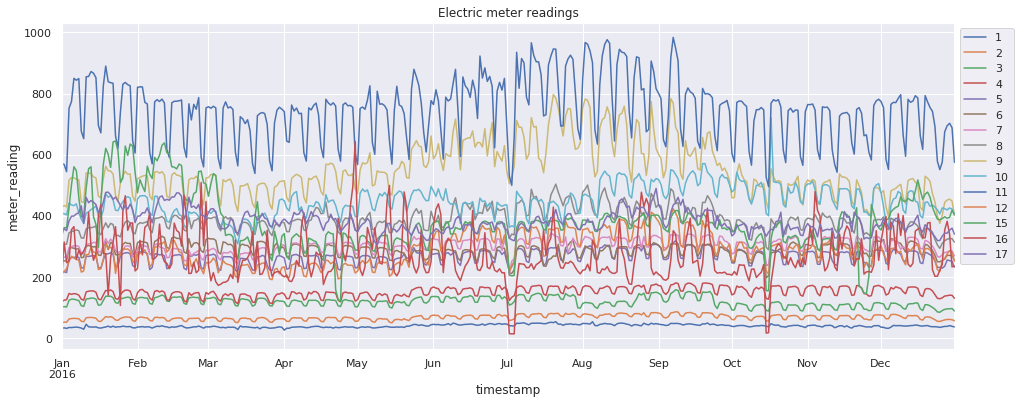

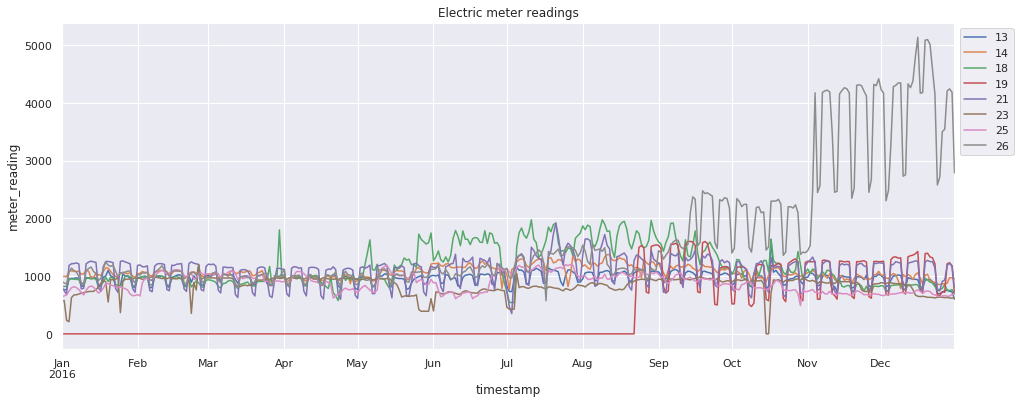

In [72]:
# Electric meter readings by floor count
udf.show_elec_readings(e_meter, by='floor_count', freq='d', cols_to_sep=[13, 14, 18, 19, 21, 23, 25, 26])

sqft_bin    -591 - 54952  54952 - 109622  109622 - 164292  164292 - 218962  \
timestamp                                                                    
2016-01-01     31.045238       88.193924       187.102356       307.828308   
2016-01-02     32.029026       91.892799       192.173157       313.649109   
2016-01-03     31.612366       89.881569       191.684067       311.036163   
2016-01-04     36.276798      108.289238       220.527390       352.844788   
2016-01-05     37.543266      111.730164       221.317444       352.731506   
...                  ...             ...              ...              ...   
2016-12-27     36.597351      103.485695       209.588318       260.908630   
2016-12-28     36.966026      105.231125       215.946915       264.628998   
2016-12-29     37.572147      107.831703       215.620682       265.274048   
2016-12-30     37.291252      105.809395       214.999710       264.897522   
2016-12-31     35.633778       97.138351       204.473846       252.394730   

sqft_bin    218962 - 273632  273632 - 328301  328301 - 382971  \
timestamp                                                       
2016-01-01       369.167389       472.094727       304.982574   
2016-01-02       372.624237       470.609131       315.186859   
2016-01-03       380.574554       463.899109       317.564087   
2016-01-04       421.132294       563.300476       397.579803   
2016-01-05       426.302216       574.562866       409.789276   
...                     ...              ...              ...   
2016-12-27       384.124542       545.510132       397.596375   
2016-12-28       391.218903       569.398560       389.493408   
2016-12-29       397.929993       569.836426       405.690002   
2016-12-30       400.983978       559.826965       389.327728   
2016-12-31       373.343994       490.336060       333.662659   

sqft_bin    382971 - 437641  437641 - 492311  492311 - 546981  \
timestamp                                                       
2016-01-01       476.406769      1340.339722       280.035553   
2016-01-02       447.841614      1308.299072       341.857819   
2016-01-03       437.121185      1291.798096       300.671173   
2016-01-04       578.673584      1502.847290       352.780182   
2016-01-05       589.180969      1557.258911       408.764496   
...                     ...              ...              ...   
2016-12-27       483.918549      1197.301392      2348.695068   
2016-12-28       505.276855      1344.809082      2893.382812   
2016-12-29       505.095490      1404.025879      2858.971191   
2016-12-30       497.653687      1406.256836      2768.611572   
2016-12-31       409.429382      1289.266357      1776.032104   

sqft_bin    546981 - 601650  656320 - 710990  710990 - 765660  \
timestamp                                                       
2016-01-01       539.606689       535.254456      2043.415283   
2016-01-02       543.278809       603.707581      2013.114624   
2016-01-03       543.430481       608.985046      1820.781616   
2016-01-04       624.206726       687.492798      2669.357666   
2016-01-05       636.168762       688.438477      2857.407471   
...                     ...              ...              ...   
2016-12-27       544.839661       687.023804      2284.882812   
2016-12-28       503.516724       691.038879      2730.989990   
2016-12-29       497.149780       690.349365      2736.998535   
2016-12-30       503.203125       683.570190      2670.138428   
2016-12-31       460.597626       617.669739      2006.667358   

sqft_bin    765660 - 820330  820330 - 875000  
timestamp                                     
2016-01-01       641.960449      1420.556885  
2016-01-02       656.871460      1348.828857  
2016-01-03       675.250000      1335.789551  
2016-01-04       740.140869      1668.173340  
2016-01-05       799.099609      1477.958374  
...                     ...              ...  
2016-12-27       661.410400      1627.162231  
2016-12-28       652.830

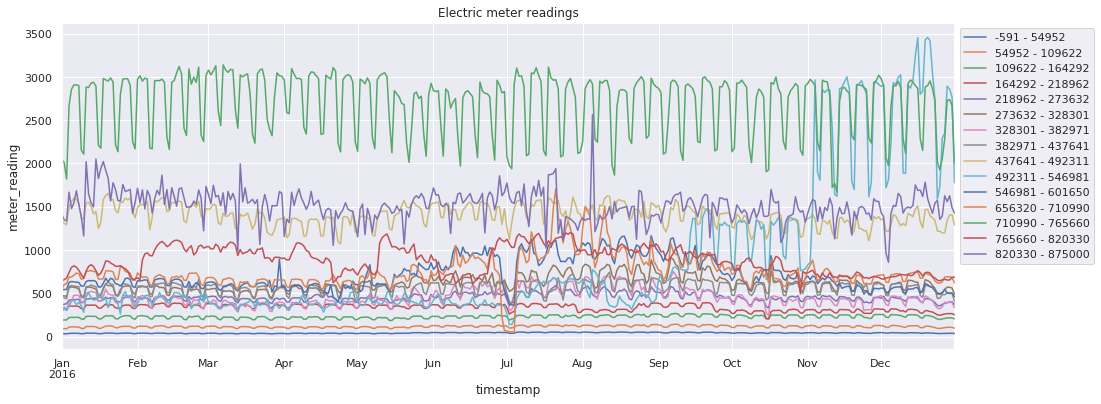

In [73]:
# Bin square_feet
e_meter['sqft_bin'] = pd.cut(e_meter.square_feet, bins=16)

# Rename bins
e_meter.sqft_bin = e_meter.sqft_bin.apply(lambda y: f'{int(y.left)} - {int(y.right)}')

# Electric meter readings by square feet
udf.show_elec_readings(e_meter, by='sqft_bin', freq='d')

In [74]:
del encoder, bldg, e_meter
gc.collect()

9878

Electric usage based on `year_built`:
- Usage in buildings that opened between 1909 and 1919 are much less than the rest
    - Could it mean these buildings are more efficient? Or do they just use less electricity in general?
- Buildings that opened between 1947 to 1957, 1986 to 1995, and 2015 to 2015 are showing the highest usage
- Peak usage most commonly occurs between February to March and August to September

Electric usage based on `primary_use` (by month):
- Religious worship buildings have the lowest usage
- Health care buildings have the highest usage, followed by education buildings
- Food sales and service buildings see a significant drop in usage in the Summer months and around New Year
- Lodging and residential buildings use the most electricity at the end of the year
- A lot of buildings show a peak in the Summer

Electric usage based on `primary_use` (by weekday):
- Usage is lower on the weekends for about half the building types
- Usage oscillates through day and night for most buildings
    - The oscillations of utility building usage has the greatest amplitude (wave height)
    - This oscillation isn't as obvious in services buildings and parking structures
- Even at night, health care buildings are using more electricity than most other buildings during the day

Electric usage based on `floor_count`:
- For the most part, as the `floor_count` increases, so does usage
    - A few of the higher `floor_count`s fall out of this linear pattern
        A lot of these higher `floor_count`s were originally missing

Electric usage based on `square_feet`:
- For the most part, as the `square_feet` increases, so does usage (just like with `floor_Count`)
    A few `square_feet` bins show usage that is higher than usual (based on the linear pattern)

##### Check the correlation between the `meter_reading` and all other features

In [75]:
# Extract month and day from timestamp
metr_bldg['month'] = metr_bldg.timestamp.dt.month
metr_bldg['day'] = metr_bldg.timestamp.dt.day

# Reorder columns
columns = ['site_id', 'building_id', 'use_encoded', 'primary_use', 'year_built', 'floor_count', 'square_feet', 'timestamp', 'month', 'day', 'hour', 'weekday', 'meter', 'type', 'meter_reading']
metr_bldg = metr_bldg[columns]
metr_bldg.head()

site_id  building_id  use_encoded primary_use  year_built  floor_count  \
0        0            0            0   Education        2008            1   
1        0            1            0   Education        2004            1   
2        0            2            0   Education        1991            1   
3        0            3            0   Education        2002            1   
4        0            4            0   Education        1975            4   

   square_feet  timestamp  month  day  hour  weekday  meter         type  \
0         7432 2016-01-01      1    1     0        4      0  electricity   
1         2720 2016-01-01      1    1     0        4      0  electricity   
2         5376 2016-01-01      1    1     0        4      0  electricity   
3        23685 2016-01-01      1    1     0        4      0  electricity   
4       116607 2016-01-01      1    1     0        4      0  electricity   

   meter_reading  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

In [76]:
# Extract columns to be used
columns = ['site_id', 'timestamp', 'air_temperature', 'dew_temperature', 'sea_level_pressure', 'cloud_coverage', 'precip_depth_1_hr', 'wind_direction', 'wind_speed']
wthr = weather[columns]

# Join the dataframes
train_df = pd.merge(metr_bldg, wthr, on=['site_id', 'timestamp'], how='left')

print(train_df.shape)
train_df.head()

(20137746, 22)


site_id  building_id  use_encoded primary_use  year_built  floor_count  \
0        0            0            0   Education        2008            1   
1        0            1            0   Education        2004            1   
2        0            2            0   Education        1991            1   
3        0            3            0   Education        2002            1   
4        0            4            0   Education        1975            4   

   square_feet  timestamp  month  day  ...  meter         type  meter_reading  \
0         7432 2016-01-01      1    1  ...      0  electricity            0.0   
1         2720 2016-01-01      1    1  ...      0  electricity            0.0   
2         5376 2016-01-01      1    1  ...      0  electricity            0.0   
3        23685 2016-01-01      1    1  ...      0  electricity            0.0   
4       116607 2016-01-01      1    1  ...      0  electricity            0.0   

  air_temperature  dew_temperature  sea_level_pressure  cloud_coverage  \
0            19.4             19.4         1019.762939             4.0   
1            19.4             19.4         1019.762939             4.0   
2            19.4             19.4         1019.762939             4.0   
3            19.4             19.4         1019.762939             4.0   
4            19.4             19.4         1019.762939             4.0   

   precip_depth_1_hr  wind_direction  wind_speed  
0                0.0           360.0         0.0  
1                0.0           360.0         0.0  
2                0.0           360.0         0.0  
3                0.0           360.0         0.0  
4                0.0           360.0         0.0  

[5 rows x 22 columns]

In [77]:
# Take a subset of the data
subset = train_df.sample(frac=0.1, random_state=42)
subset.shape

(2013775, 22)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 <a list of 19 Text xticklabel objects>)

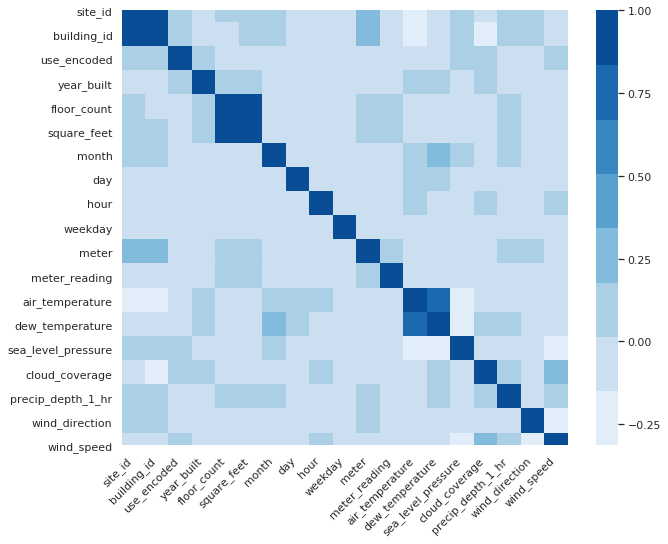

In [78]:
# Pearson correlation
pearson = train_df.corr()

fig = plt.figure(figsize=(10, 8))
sns.heatmap(pearson, cmap=sns.color_palette('Blues', 8))
plt.xticks(rotation=45, ha='right')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 <a list of 19 Text xticklabel objects>)

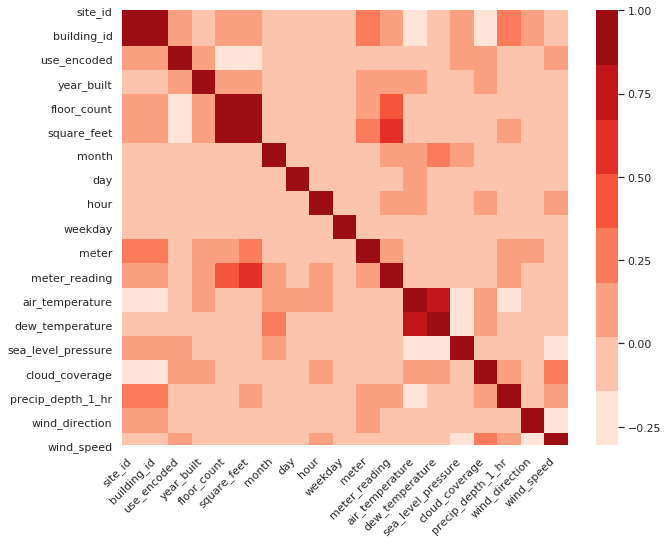

In [79]:
# Spearman correlation
spearman = subset.corr(method='spearman')

fig = plt.figure(figsize=(10, 8))
sns.heatmap(spearman, cmap=sns.color_palette('Reds', 8))
plt.xticks(rotation=45, ha='right')

Text(0.5, 0, 'Pearson coefficient')

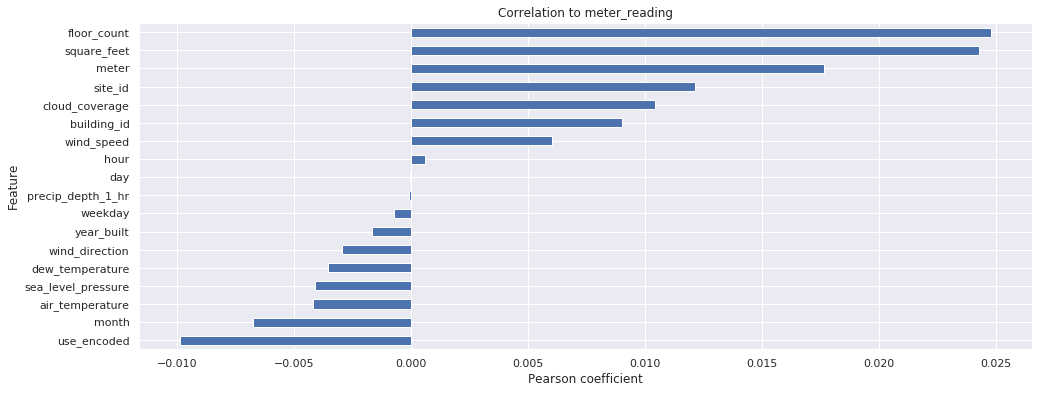

In [80]:
# Pearson correlation
pearson.meter_reading.sort_values()[:-1].plot(kind='barh', figsize=(16, 6))
plt.title('Correlation to meter_reading')
plt.ylabel('Feature')
plt.xlabel('Pearson coefficient')

Text(0.5, 0, 'Spearman coefficient')

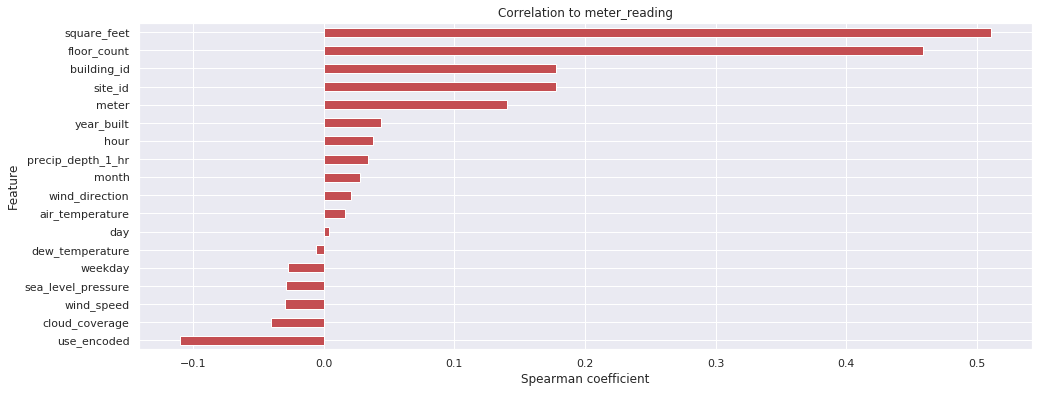

In [81]:
# Spearman correlation
spearman.meter_reading.sort_values()[:-1].plot(kind='barh', figsize=(16, 6), color='r')
plt.title('Correlation to meter_reading')
plt.ylabel('Feature')
plt.xlabel('Spearman coefficient')

In [82]:
train_df.drop(['hour', 'month', 'day', 'weekday'], axis=1, inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20137746 entries, 0 to 20137745
Data columns (total 18 columns):
site_id               uint8
building_id           uint16
use_encoded           uint8
primary_use           category
year_built            uint16
floor_count           uint8
square_feet           uint32
timestamp             datetime64[ns]
meter                 uint8
type                  category
meter_reading         float32
air_temperature       float32
dew_temperature       float32
sea_level_pressure    float32
cloud_coverage        float64
precip_depth_1_hr     float32
wind_direction        float64
wind_speed            float32
dtypes: category(2), datetime64[ns](1), float32(6), float64(2), uint16(2), uint32(1), uint8(4)
memory usage: 1.3 GB


In [83]:
del pearson, spearman, subset, metr_bldg, wthr, columns, fig
gc.collect()

44

The size of the building is showing the greatest correlation with `meter_reading` so `square_feet` and `floor_count` may be the most important features when modeling.

The building and meter dataframes were edited here and the combined dataframe was newly created.

##### Save these dataframes into csv files

In [85]:
building.to_csv(f'{data_path}eda_building.csv')
meter.to_csv(f'{data_path}eda_meter.csv')
train_df.to_csv(f'{data_path}eda_train.csv')

[Back to top](#content1)